# OTOC para BKP

Lo que intentaremos hacer en este programa será evaluar el siguiente operador (OTOC) como valor de expectación en un circuito cuántico:
$$
O(t) = e^{-\beta H/2}W^\dagger V^\dagger(t) W e^{-\beta H/2} V(t) 
$$
$$
{\rm Tr}( O(t) ) = \bra{\psi}O(t)  \otimes  \mathbb{I}\ket{\psi}
$$

donde $\ket{\psi}=\sum_{i}\ket{i}\otimes\ket{i}=\sum_{i}U_i\ket{0}\otimes\ket{0}$.

Como no podemos evaluar directamente el elemento de matriz, lo que haremos será evaluar la probabilidad de medir el estado $\ket{0}$:
$$
\left | \bra{\psi}O(t)  \otimes  \mathbb{I}\ket{\psi}\right |^2


In [120]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate ,PauliGate
from qiskit.synthesis import LieTrotter,MatrixExponential
from qiskit.visualization import array_to_latex
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import Estimator, StatevectorEstimator, Sampler

from scipy.linalg import expm


## Preparamos los operadores

### Establecemos los parámetros del circuito

In [121]:
N=3
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.zeros(N)#np.array([0.0316079, 0.00519953 ,0.0283397]) 
#h = np.array([0.316079, 0.0519953 ,0.283397])      # magnetic field
#g = np.pi / 2  # interaction coupling strength

### Hamiltoniano BKP

El hamiltoniano será de la siguiente manera $H=H_K H_I$ donde
$$
H_K=b\sum_{j}^{n}\sigma_j^x \\
H_I=J\sum_j^{n-1}\sigma_j^z\sigma_{j+1}^z + \sum_j^n h_j \sigma_j^z
$$

In [122]:
#Creamos las puertas de Pauli en listas para hacerlo de manera general, para todo N.

terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()

H_K

SparsePauliOp(['XII', 'IXI', 'IIX'],
              coeffs=[0.78539816+0.j, 0.78539816+0.j, 0.78539816+0.j])

#### Hamiltoniano Ising

In [123]:
def H_transverse_Ising(J, b, h, N):
    # In order to define the hamiltonian we first want to create lists with all the possible combinations
    terms_hopping = ['I'*i + 'XX' + 'I'*(N-2-i) for i in range(N-1)]
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]

    H_hopping=sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])
    H_site_Z = sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_Z])
    H_site_X = sum([SparsePauliOp.from_list([(term, h)]) for term in terms_site_X])

    return H_hopping  + H_site_Z + H_site_X 


h1=H_transverse_Ising(1, 1, 0.5, N)

### Operador evolución

El operador evolución, en consecuencia al hamiltoniano que hemos construido, será $U=U_K U_I=exp(itH)$

In [124]:
def U(h,t):
    U = PauliEvolutionGate(h, time=t, synthesis=MatrixExponential())
    return U



### Operadores V y W

Definimos los operadores $V = \sigma^x_{[N/2]}$ y $W = \sigma^x_{[N/2] + 1}$

In [125]:
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

### OTOC

$$
O(t) = e^{-\beta H/2}W^\dagger V^\dagger(t) W e^{-\beta H/2} V(t) 
$$
$$
|{\rm Tr}( O(t) )|^2 = |\bra{\psi}O(t)  \otimes  \mathbb{I}\ket{\psi}|^2
$$

In [126]:
def OpHeis(OpSch,t): #Evolución temporal de un operador
    for temp in range(t):
        qc.append(U(H_I,1), left_reg)
        qc.append(U(H_K,1), left_reg)
    
    qc.append(OpSch, left_reg)

    for temp in range(t):
        qc.append(U(H_K,-1), left_reg)
        qc.append(U(H_I,-1), left_reg)


def OTOC(V,W,t):
    V_adjoint = Operator(V).adjoint()
    W_adjoint = Operator(W).adjoint()
    OpHeis(V,t)
    qc.append(W, left_reg)
    OpHeis(V_adjoint,t)
    qc.append(W_adjoint,left_reg)


###  Inicializamos el estado

Cremos pares de Bell $\left ( \ket{TFD (0)} \right) $

In [127]:
def initialize():
    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])

#Imprimo un estado para ver que se está aplicando correctamente
left_reg = QuantumRegister(N, 'Left')
right_reg = QuantumRegister(N, 'Right')
qc=QuantumCircuit(left_reg,right_reg)
for i in range(N):
    qc.h(left_reg[i])
    qc.cx(left_reg[i], right_reg[i])

from qiskit.quantum_info import Statevector

bell_state = Statevector(qc)
bell_state.draw('latex')


<IPython.core.display.Latex object>

## Circuito

Ya habiendo construido todos los elementos vamos a hacer el circuito cuántico. La idea es parecida a la de QGLab. Hacer dos sets de qubits entrelazados y, en este caso, hacer actuar los operadores sobre un set solamente. Por analogía los llamaré también left y right.

Usaremos la clase Sampler para medir directamente las probabilidades de obtener el estado $\ket{0}$.

In [128]:
tmax=10
#t_target, steps = 4, 80
#t_eval = np.linspace(0,t_target, steps + 1)
t_eval=list(range(tmax+1))


left_reg = QuantumRegister(N, 'Left')
right_reg = QuantumRegister(N, 'Right')

res = []

estimator_v2 = StatevectorEstimator()
sampler_v1 = Sampler() 



for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)
     
    initialize()
    
    qc.barrier()
     
    OTOC(V,W,t)
    
    #Deshacemos el estado inicial (EPR)
    for i in range(N-1, -1, -1):
        qc.cx(left_reg[i], right_reg[i])
        qc.h(left_reg[i])
    
    
    bell_state = Statevector(qc) #Pruebas analiticas, si se quiere ejecutar en computadora cuantica real se tiene que quitar

    

    qc.measure_all()

    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)


bell_state.draw('latex')



<IPython.core.display.Latex object>

### Sacamos los ceros

El resultado que nos devuelve Sampler serán de tipo diccionario, extraemos los valores esperados de medir 0.

In [129]:
ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    try:
        ceros.append(round(cero,6))
    except:
        ceros.append(0)
ceros


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### Representación

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


<function matplotlib.pyplot.show(close=None, block=None)>

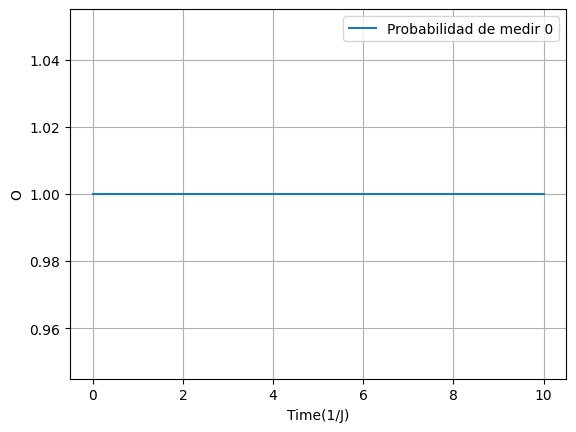

In [130]:
plt.figure(facecolor='white')
print(ceros)
cerosnorm=ceros/ceros[0]
plt.plot(t_eval,cerosnorm, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

# Destripando el circuito 

Vamos a hacer medidas en cada uno de los pasos a ver que está pasando y por qué no está Scrambleando.

## Inicio circuito

<IPython.core.display.Latex object>

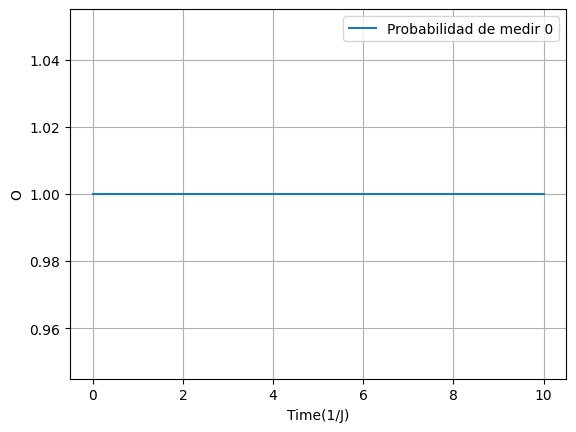

In [131]:
res = []


for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)
    qc.measure_all()
    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)

# bell_state = Statevector(qc)


ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    ceros.append(round(cero,6))

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

bell_state.draw('latex')


## Inicio TFD

<function matplotlib.pyplot.show(close=None, block=None)>

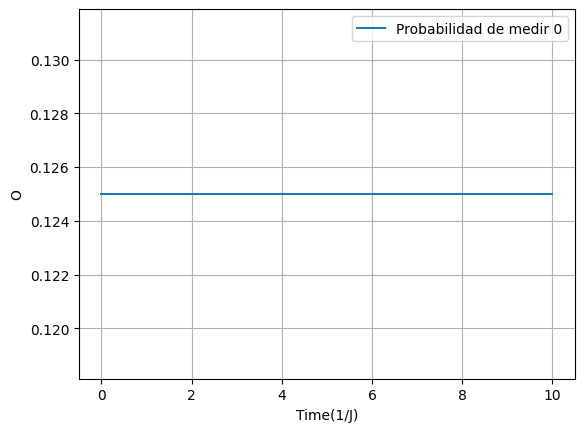

In [132]:
res = []


for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)

    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])

    qc.measure_all()
    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)


ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    ceros.append(round(cero,6))

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

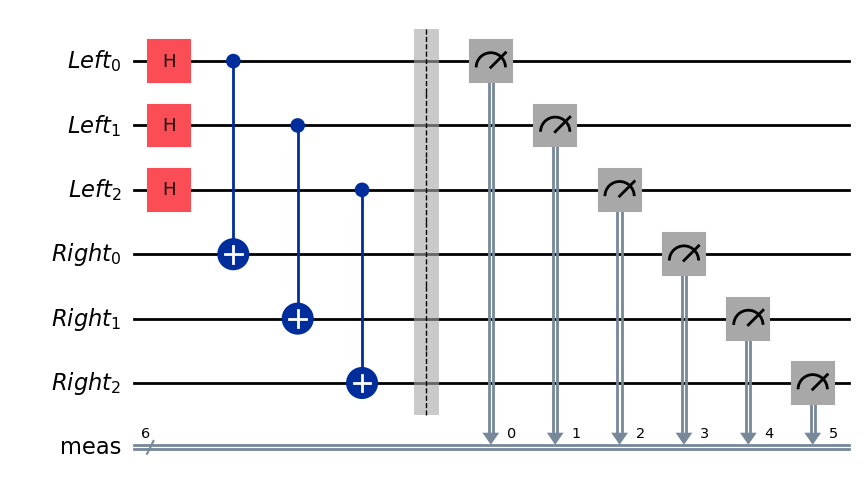

In [133]:
qc.draw('mpl')

## OTOC

$$
O(t) = e^{-\beta H/2}W^\dagger V^\dagger(t) W e^{-\beta H/2} V(t) 
$$
$$
{\rm Tr}( O(t) ) = \bra{\psi}O(t)  \otimes  \mathbb{I}\ket{\psi}
$$

### V(t)

[{4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}]


<function matplotlib.pyplot.show(close=None, block=None)>

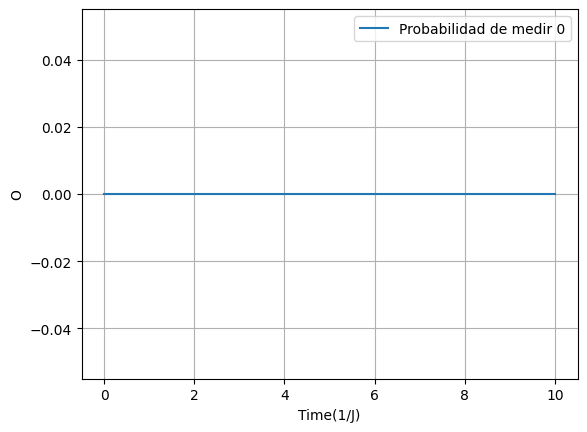

In [134]:
res = []

for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)

    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])

    qc.barrier()

    qc.append(V, left_reg)

    qc.measure_all()
    

    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)

print(res)
ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    try:
        ceros.append(round(cero,6))
    except:
        ceros.append(0)
    
    

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show


Instruction(name='pauli', num_qubits=3, num_clbits=0, params=['XII'])
[{4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {2: 0.125, 11: 0.125, 16: 0.125, 25: 0.125, 38: 0.125, 47: 0.125, 52: 0.125, 61: 0.125}, {1: 0.125, 8: 0.125, 19: 0.125, 26: 0.125, 37: 0.125, 44: 0.125, 55: 0.125, 62: 0.125}, {1: 0.125, 8: 0.125, 19: 0.125, 26: 0.125, 37: 0.125, 44: 0.125, 55: 0.125, 62: 0.125}, {2: 0.125, 11: 0.125, 16: 0.125, 25: 0.125, 38: 0.125, 47: 0.125, 52: 0.125, 61: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {4: 0.125, 13: 0.125, 22: 0.125, 31: 0.125, 32: 0.125, 41: 0.125, 50: 0.125, 59: 0.125}, {2: 0.125, 11: 0.125, 16: 0.125, 25: 0.125, 38: 0.125, 47: 0.125, 52: 0.125, 61: 0.125}, {1: 0.125, 8: 0.125, 19: 0.125, 26: 0.125, 37: 0.125, 44: 0.125, 55: 0.125, 62: 0.125}, {1: 0.125, 8: 0.125, 19: 0.125, 26: 0.125,

<function matplotlib.pyplot.show(close=None, block=None)>

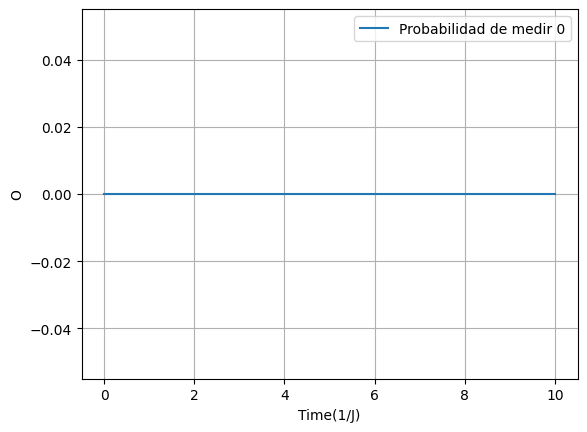

In [135]:
res = []
print(V)

for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)
    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])
    qc.barrier()
    OpHeis(V,t)
    qc.measure_all()
    

    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)
print(res)

ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    try:
        ceros.append(round(cero,6))
    except:
        ceros.append(0)
    
    

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

#### Idea



### W

<function matplotlib.pyplot.show(close=None, block=None)>

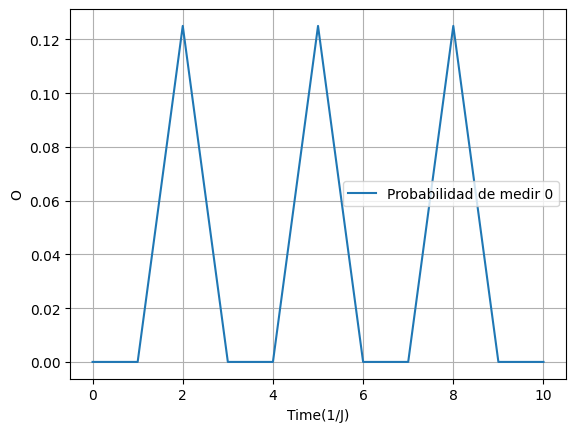

In [136]:
res = []

for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)

    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])

    qc.barrier()

    OpHeis(V,t)
    qc.append(W, left_reg)


    qc.measure_all()
    

    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)


ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    try:
        ceros.append(round(cero,6))
    except:
        ceros.append(0)
    
    

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

### $V^\dagger(t)$

<function matplotlib.pyplot.show(close=None, block=None)>

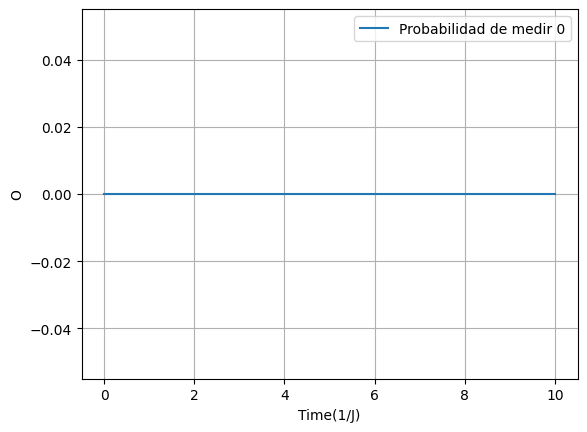

In [137]:
res = []
V_adjoint = Operator(V).adjoint()


for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)

    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])

    qc.barrier()

    OpHeis(V,t)
    qc.append(W, left_reg)
    OpHeis(V_adjoint, t)


    qc.measure_all()
    

    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)


ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    try:
        ceros.append(round(cero,6))
    except:
        ceros.append(0)
    
    

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

### $W^\dagger$

<function matplotlib.pyplot.show(close=None, block=None)>

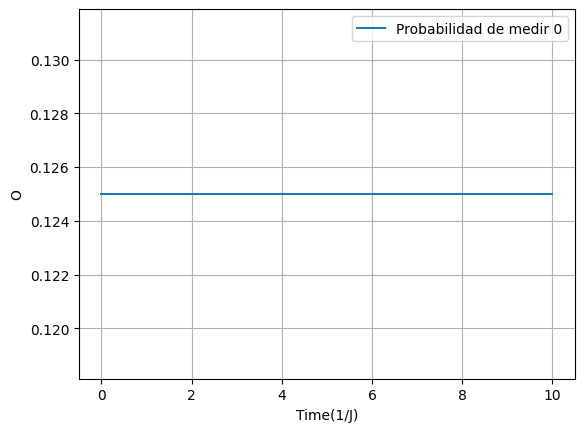

In [138]:
res = []
V_adjoint = Operator(V).adjoint()
W_adjoint = Operator(W).adjoint()


for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)

    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])

    qc.barrier()

    OpHeis(V,t)
    qc.append(W, left_reg)
    OpHeis(V_adjoint, t)
    qc.append(W_adjoint, left_reg)


    qc.measure_all()
    

    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)


ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    try:
        ceros.append(round(cero,6))
    except:
        ceros.append(0)
    
    

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

## Deshacemos TFD

<function matplotlib.pyplot.show(close=None, block=None)>

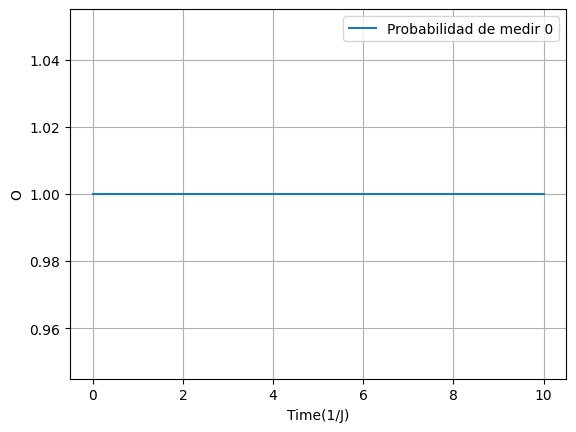

In [139]:
res = []
V_adjoint = Operator(V).adjoint()
W_adjoint = Operator(W).adjoint()


for t in range(len(t_eval)):
    qc = QuantumCircuit(left_reg, right_reg)

    for i in range(N):
        qc.h(left_reg[i])
        qc.cx(left_reg[i], right_reg[i])

    qc.barrier()

    OpHeis(V,t)
    qc.append(W, left_reg)
    OpHeis(V_adjoint, t)
    qc.append(W_adjoint, left_reg)


    for i in range(N-1, -1, -1):
        qc.cx(left_reg[i], right_reg[i])
        qc.h(left_reg[i])
    
    qc.measure_all()
    

    job = sampler_v1.run(qc)
    dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
    res.append(dists)


ceros=[]

for i in range(len(res)):
    cero=res[i].get(0)
    try:
        ceros.append(round(cero,6))
    except:
        ceros.append(0)
    
    

plt.figure(facecolor='white')
plt.plot(t_eval,ceros, label="Probabilidad de medir 0")
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show

# Conclusiones/Ideas

La V hace que la probabilidad de medir 0 sea 0. O sea, cambia los qubits de tal manera que no son todos 0 nunca.

Cuando $W^\dagger$ actúa sobre el estado, hace que la probabilidad de medir todo 0s sea la misma que en el TFD. Lo que indica que hace el mismo efecto que el TFD y por eso al deshacerlo la probabilidad vuelve a ser 1.

In [140]:

left_reg = QuantumRegister(N, 'Left')
right_reg = QuantumRegister(N, 'Right')

qc = QuantumCircuit(left_reg, right_reg)
for i in range(N):
    qc.h(left_reg[i])
    qc.cx(left_reg[i], right_reg[i])

qc.append(U(H_I,1),left_reg)
qc.append(U(H_K,1),left_reg)
from qiskit.quantum_info import Statevector
bell_state = Statevector(qc)

qc.measure_all()
job = sampler_v1.run(qc)
dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists

print(dists)

qc.draw('mpl')

bell_state.draw('latex')

{0: 0.015625, 1: 0.015625, 2: 0.015625, 3: 0.015625, 4: 0.015625, 5: 0.015625, 6: 0.015625, 7: 0.015625, 8: 0.015625, 9: 0.015625, 10: 0.015625, 11: 0.015625, 12: 0.015625, 13: 0.015625, 14: 0.015625, 15: 0.015625, 16: 0.015625, 17: 0.015625, 18: 0.015625, 19: 0.015625, 20: 0.015625, 21: 0.015625, 22: 0.015625, 23: 0.015625, 24: 0.015625, 25: 0.015625, 26: 0.015625, 27: 0.015625, 28: 0.015625, 29: 0.015625, 30: 0.015625, 31: 0.015625, 32: 0.015625, 33: 0.015625, 34: 0.015625, 35: 0.015625, 36: 0.015625, 37: 0.015625, 38: 0.015625, 39: 0.015625, 40: 0.015625, 41: 0.015625, 42: 0.015625, 43: 0.015625, 44: 0.015625, 45: 0.015625, 46: 0.015625, 47: 0.015625, 48: 0.015625, 49: 0.015625, 50: 0.015625, 51: 0.015625, 52: 0.015625, 53: 0.015625, 54: 0.015625, 55: 0.015625, 56: 0.015625, 57: 0.015625, 58: 0.015625, 59: 0.015625, 60: 0.015625, 61: 0.015625, 62: 0.015625, 63: 0.015625}


<IPython.core.display.Latex object>

# Prubeas

### Código

In [141]:
def prueba(N,b,J,h ,V, W,t_eval):

    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

    H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
    H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()



    def OpHeis(OpSch,t): #Evolución temporal de un operador
        for temp in range(t):
            qc.append(U(H_I,1), left_reg)
            qc.append(U(H_K,1), left_reg)
        
        qc.append(OpSch, left_reg)

        for temp in range(t):
            qc.append(U(H_K,-1), left_reg)
            qc.append(U(H_I,-1), left_reg)

    left_reg = QuantumRegister(N, 'Left')
    right_reg = QuantumRegister(N, 'Right')

    res = []

    # estimator_v2 = StatevectorEstimator()
    sampler_v1 = Sampler() 
    V=Operator(V)
    W=Operator(W)
    V_adjoint = V.adjoint()
    W_adjoint = W.adjoint()

    for t in range(len(t_eval)):
        qc = QuantumCircuit(left_reg, right_reg)

        for i in range(N):
            qc.h(left_reg[i])
            qc.cx(left_reg[i], right_reg[i])

        qc.barrier()

       #OTOC    
        OpHeis(V,t_eval[t])
        qc.append(W, left_reg)
        OpHeis(V_adjoint,t_eval[t])
        qc.append(W_adjoint,left_reg)


        for i in range(N-1, -1, -1):
            qc.cx(left_reg[i], right_reg[i])
            qc.h(left_reg[i])
        qc.measure_all()
        

        job = sampler_v1.run(qc)
        dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
        res.append(dists)

    ceros=[]

    for i in range(len(res)):
        cero=res[i].get(0)
        ceros.append(round(cero,6)**0.5) #debería ser la raíz cuadrada????? Si
    return ceros


def ploteo(cero, t, N, b, J):
    plt.figure(facecolor='white')
    cerosnorm = cero / cero[0]
    b_formatted = "{:.4f}".format(b)
    J_formatted = "{:.4f}".format(J)
    plt.plot(t, cerosnorm, label=f"N={N}, b={b_formatted}, J={J_formatted}")
    plt.xlabel(r'Time(1/J)')
    plt.ylabel(r'O')
    plt.legend()
    plt.grid()
    plt.show()

def ploteo1(cero, t, N, h):
    plt.figure(facecolor='white')
    cerosnorm = cero / cero[0]
    h_formatted = ["{:.4f}".format(val) for val in h]
    h_str = ", ".join(h_formatted)
    plt.plot(t, cerosnorm, label=f"N={N}, h={h_str}")
    plt.xlabel(r'Time(1/J)')
    plt.ylabel(r'O')
    plt.legend()
    plt.grid()
    plt.show()

In [142]:
def BKP(N,b,J,h_random):
    
    h = np.random.rand(N)*h_random
    h=h_random
    # h=np.array([0.13609651, 0.07815507, 0.17859231, 0.1243914,  0.07171081, 0.02446947, 0.17582692, 0.0140984 ])    
    print(h)
    #Hamiltonian
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

    H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
    H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()

    # Pasamos los hamiltonianos a matrices
    H_K_matrix = H_K.to_matrix()
    H_I_matrix = H_I.to_matrix()

    # Hacemos el operador de evolución temporal de un paso
    U_K = expm(-1j * H_K_matrix)
    U_I = expm(-1j * H_I_matrix)

    U = U_K@U_I
    U_dag = np.conj(U).T


    return U, U_dag

def ising(N,b,J,h_random):
    
    h = h_random
    #Hamiltonian
    # In order to define the hamiltonian we first want to create lists with all the possible combinations
    terms_hopping = ['I'*i + 'XX' + 'I'*(N-2-i) for i in range(N-1)]
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]

    H_hopping=sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])
    H_site_Z = sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_Z])
    H_site_X = sum([SparsePauliOp.from_list([(term, h_random)]) for term in terms_site_X])

    H = H_hopping  + H_site_Z + H_site_X 

    # Pasamos los hamiltonianos a matrices
    H_matrix = H.to_matrix()

    # Hacemos el operador de evolución temporal de un paso
    U = expm(-1j * H_matrix)
    U_dag = np.conj(U).T


    return U, U_dag



### OTOC

$$
O(t) = e^{-\beta H/2}W^\dagger V^\dagger(t) W e^{-\beta H/2} V(t) 
$$
$$
|\frac{1}{2^N}{\rm Tr}( O(t) )|^2 = |\bra{\psi}O(t)  \otimes  \mathbb{I}\ket{\psi}|^2
$$

In [143]:

def OTOC_tr(time, V,W, N, b, J, h_random):
    # Hamiltonian
    U, U_dag = BKP(N, b, J, h_random)
    V_t = V.to_matrix()
    W=W.to_matrix()
    V_dag = np.conj(V_t).T
    W_dag = np.conj(W).T
  
    otoc_tr=[]

    for t in time:
        print(t)
        otoc=W_dag@V_dag@W@V_t
        V_t = U_dag@V_t@U
        V_dag = np.conj(V_t).T

        otoc_tr.append(np.abs((1/2**N)*np.trace(otoc)))
    
    
    return otoc_tr

def OTOC_tr_ising(time, V,W, N, b, J, h_random):
    # Hamiltonian
    U, U_dag = ising(N, b, J, h_random)
    V_t = V.to_matrix()
    W=W.to_matrix()
    V_dag = np.conj(V_t).T
    W_dag = np.conj(W).T
  
    otoc_tr=[]

    for t in time:
        print(t)
        otoc=W_dag@V_dag@W@V_t
        V_t = U_dag@V_t@U
        V_dag = np.conj(V_t).T

        otoc_tr.append(np.abs((1/2**N)*np.trace(otoc)))
    
    
    return otoc_tr


## N=2, J=b=$\frac{\pi}{4}$, h=0, V=XI, W=IX

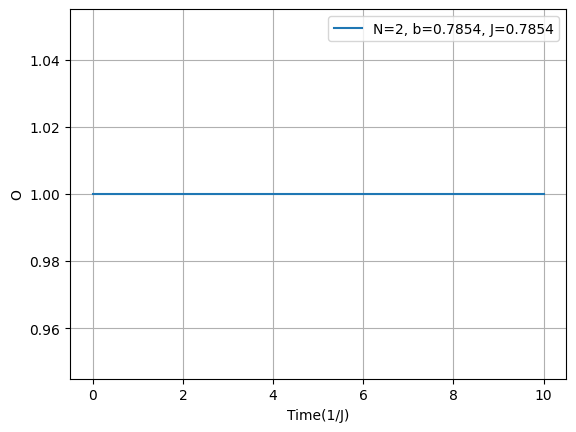

In [144]:
N=2

b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.zeros(N)

V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(11))

cero=prueba(N,b,J,h, V, W, t_eval)

ploteo(cero,t_eval, N, b, J)



## N=3, J=b=variando, h=0, V=XII, W=IXI

In [145]:
np.pi/4

0.7853981633974483

In [146]:
N=3
h = np.zeros(N)
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')

for i,bp in enumerate(b):
    cero = prueba(N,bp,np.pi/4,h, V, W, t_eval)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero = prueba(N,np.pi/4,np.pi/4,h, V, W, t_eval)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=3, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h=0$")


plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show()


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
h = np.random.rand(N)*0.2
h

array([0.19746523, 0.05561701, 0.00075873])

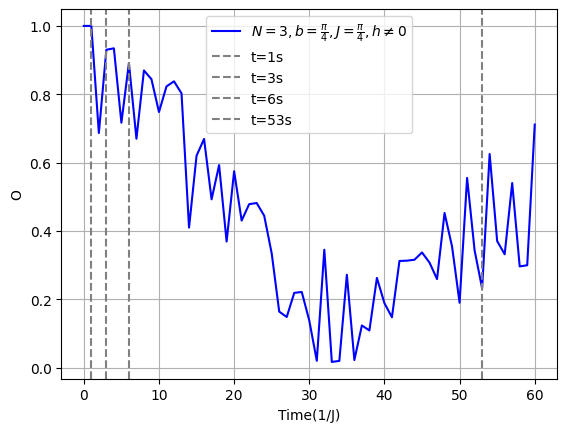

In [ ]:
N=3
h = np.array([0.19746523, 0.05561701, 0.00075873])
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(61))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')

# for i,bp in enumerate(b):
#     cero = prueba(N,bp,np.pi/4,h, V, W, t_eval)
#     cerosnorm = cero / cero[0]

#     plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero = prueba(N,np.pi/4,np.pi/4,h, V, W, t_eval)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=3, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h\neq0$")

plt.axvline(x=1, color='grey', linestyle='--',label='t=1s')
plt.axvline(x=3, color='grey', linestyle='--',label='t=3s')
plt.axvline(x=6, color='grey', linestyle='--',label='t=6s')
plt.axvline(x=53, color='grey', linestyle='--',label='t=53s')
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.savefig('OTOC BKP estrella N=3.png', dpi=400)
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


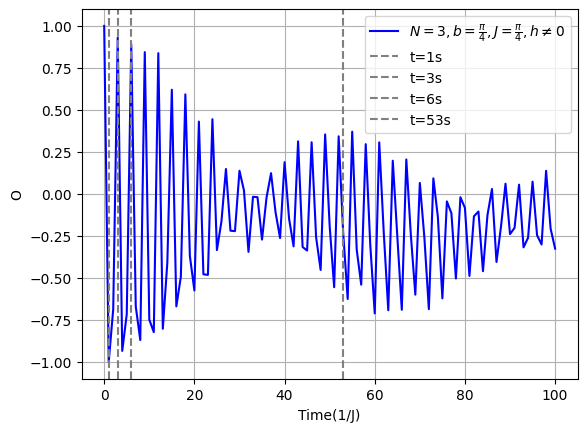

In [ ]:
N=3
h = np.array([0.19746523, 0.05561701, 0.00075873])
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(101))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')

# for i,bp in enumerate(b):
#     cero = prueba(N,bp,np.pi/4,h, V, W, t_eval)
#     cerosnorm = cero / cero[0]

#     plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])
cero=OTOC_tr(t_eval, V,W, N, np.pi/4, np.pi/4, h)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=3, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h\neq0$")

plt.axvline(x=1, color='grey', linestyle='--',label='t=1s')
plt.axvline(x=3, color='grey', linestyle='--',label='t=3s')
plt.axvline(x=6, color='grey', linestyle='--',label='t=6s')
plt.axvline(x=53, color='grey', linestyle='--',label='t=53s')
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.savefig('OTOC traza BKP estrella N=3.png', dpi=400)
plt.show()

## N=10 pruebas

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


c:\Users\manue\anaconda3\envs\qutip\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\manue\anaconda3\envs\qutip\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

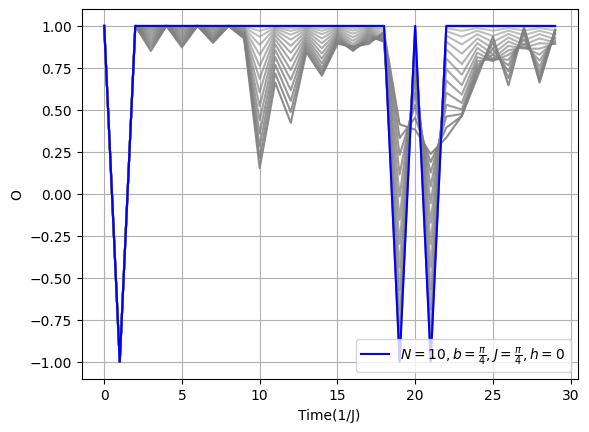

In [ ]:
N=10
h = np.zeros(N)
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')



for i,bp in enumerate(b):
    cero=OTOC_tr(t_eval, V,W, N, bp, np.pi/4, h)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero=OTOC_tr(t_eval, V,W, N, np.pi/4, np.pi/4, h)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=10, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h=0$")


plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
12
0
1
2
3
4
5

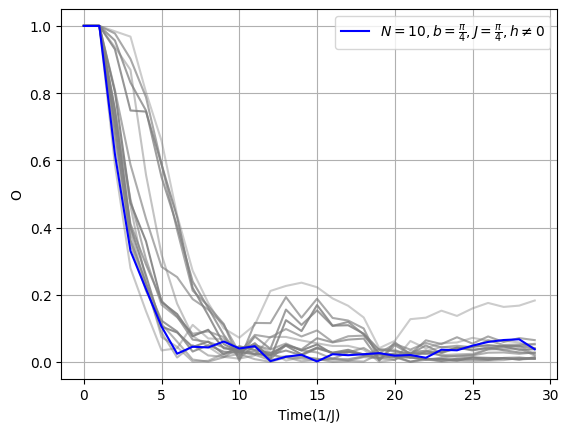

In [ ]:
N=10
h = 0.2
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')



for i,bp in enumerate(b):
    print(i)
    cero=OTOC_tr(t_eval, V,W, N, bp, np.pi/4, h)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero=OTOC_tr(t_eval, V,W, N, np.pi/4, np.pi/4, h)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=10, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h\neq0$")


plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.savefig('OTOC traza BKP estrella N=10.png', dpi=400)
plt.show()

## N=8 (TFG)

0
[0.01044837 0.05760976 0.07093719 0.15558772 0.07337934 0.00437979
 0.02806242 0.11174344]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
1
[0.01044837 0.05760976 0.07093719 0.15558772 0.07337934 0.00437979
 0.02806242 0.11174344]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
10

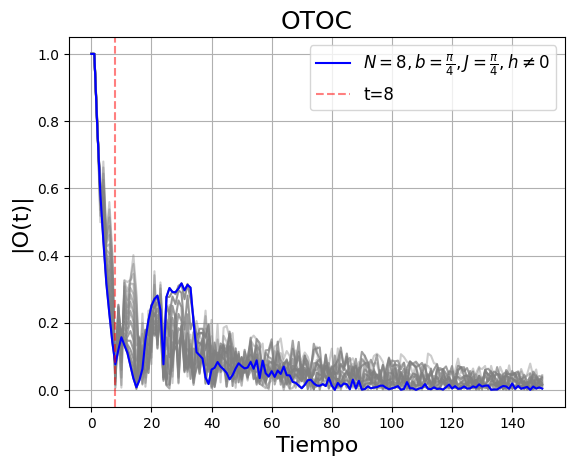

In [159]:
N=8
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])
# h = np.random.rand(N)*0.2-0.1

V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(151))

b = np.linspace((np.pi/4), (np.pi/4)+0.15, 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(9,facecolor='white')



for i,bp in enumerate(b):
    print(i)
    cero=OTOC_tr(t_eval, V,W, N, bp, np.pi/4, h)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero=OTOC_tr(t_eval, V,W, N, np.pi/4, np.pi/4, h)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm,'-' ,color='blue', label=r"$N=8, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h\neq0$")

plt.axvline(x=8, color='red', linestyle='--',label='t=8',alpha=0.5)
plt.xlabel(r'Tiempo', fontsize=16)
plt.ylabel(r'|O(t)|', fontsize=16)
plt.title('OTOC', fontsize=18)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('OTOC traza BKP solo N=8 varioss bueno bueno t=150.pdf', dpi=400)
plt.show()

In [118]:
np.min(cerosnorm[:65])

0.007880864359180985

## N=3

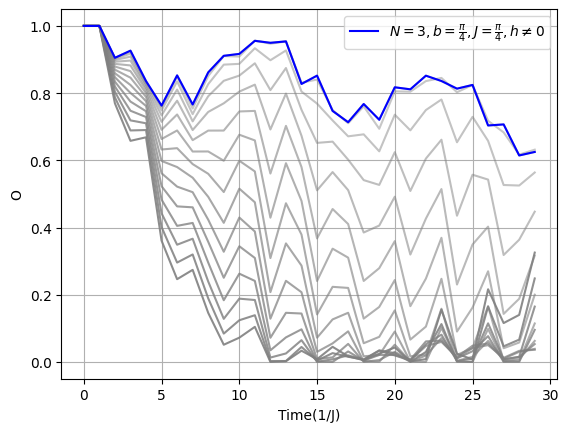

In [24]:
N=3
h = np.random.rand(N)*0.2
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')

for i,bp in enumerate(b):
    cero = prueba(N,bp,np.pi/4,h, V, W, t_eval)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero = prueba(N,np.pi/4,np.pi/4,h, V, W, t_eval)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=3, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h \neq  0$")


plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show()

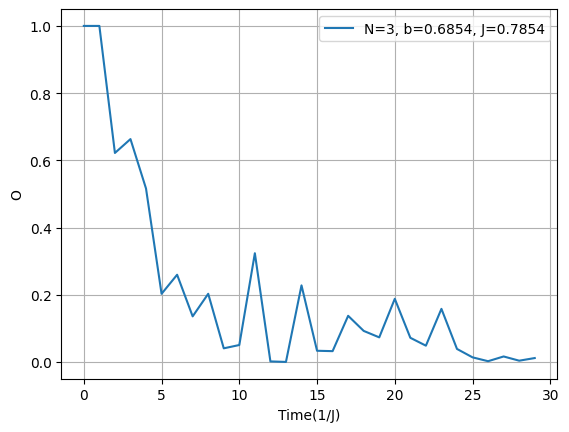

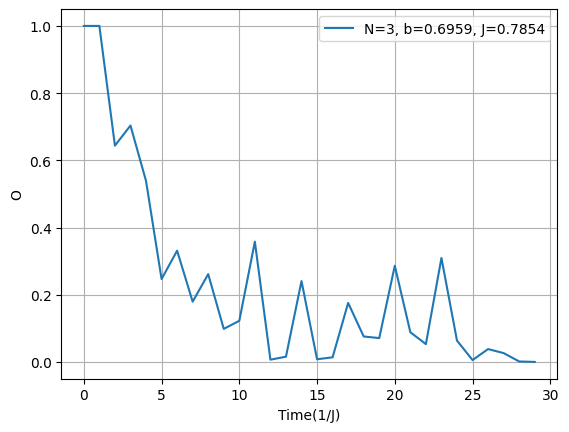

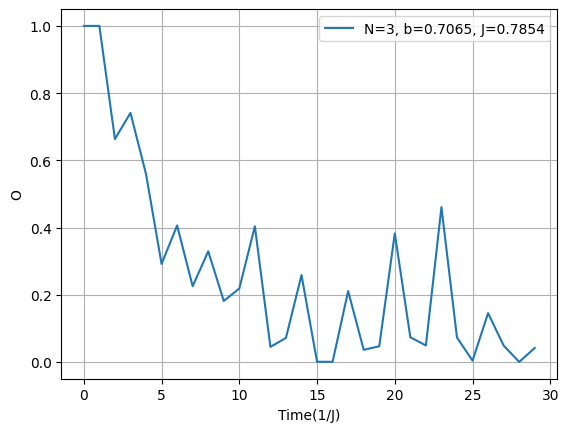

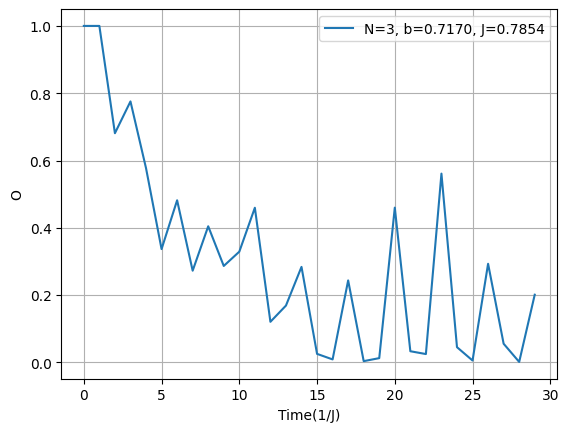

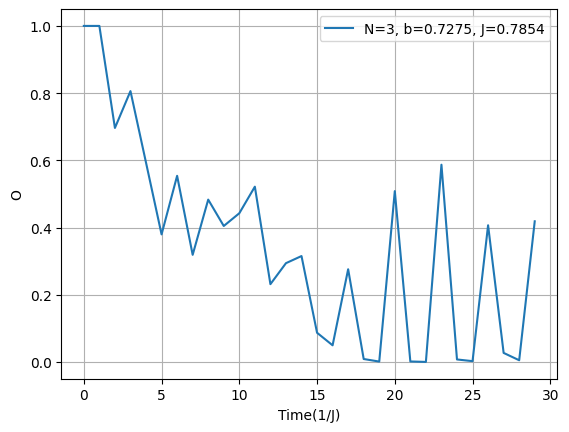

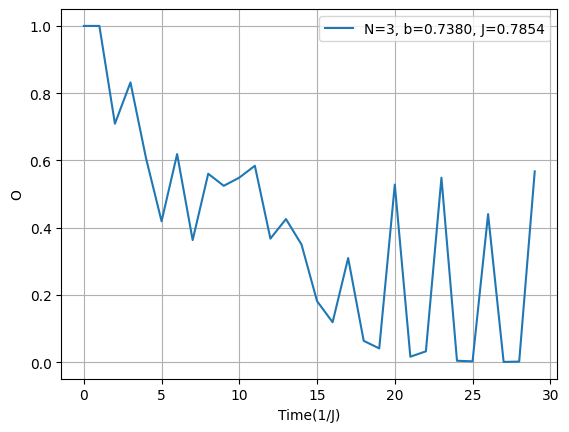

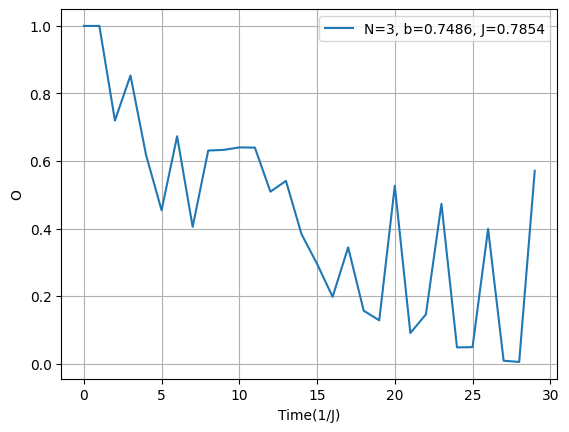

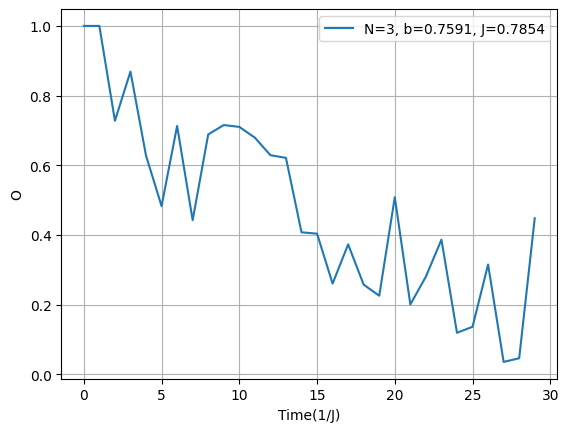

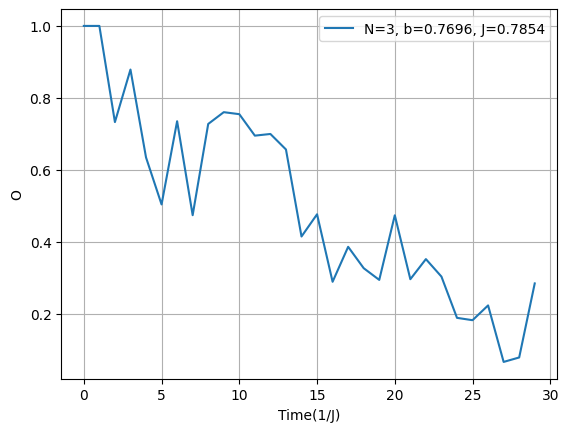

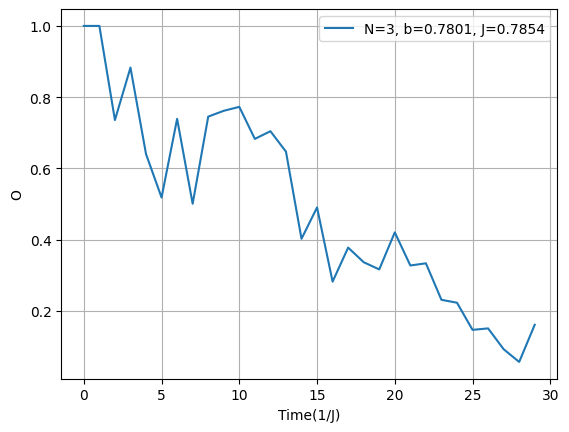

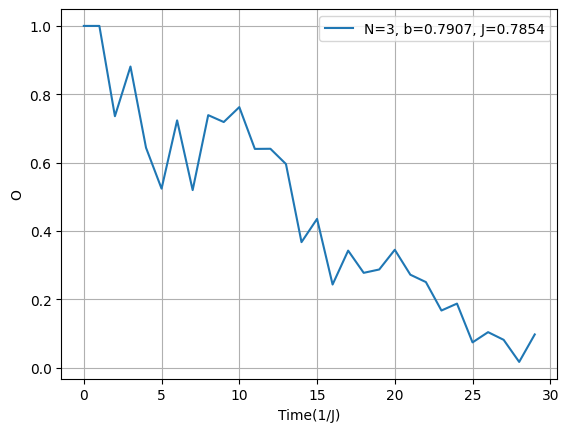

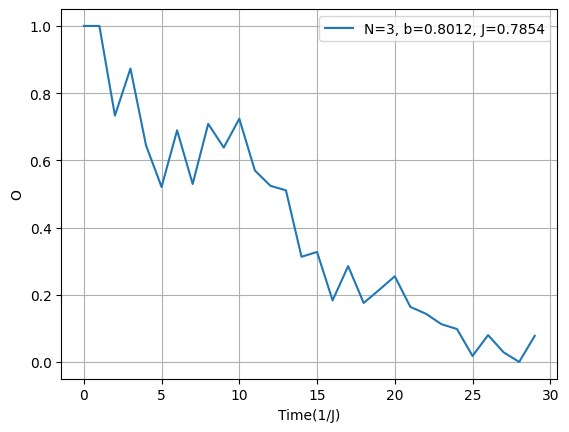

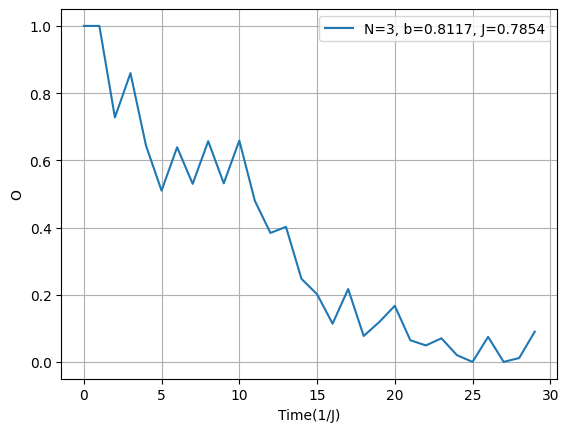

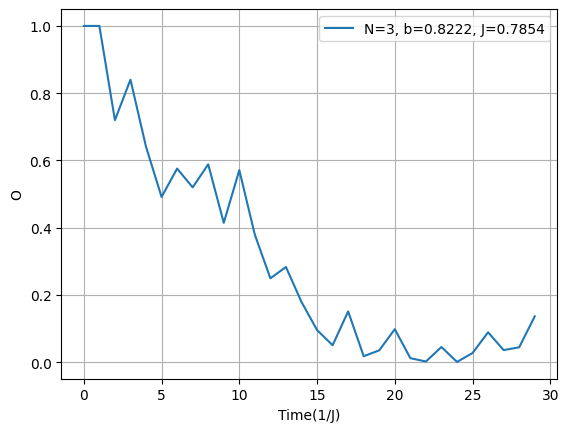

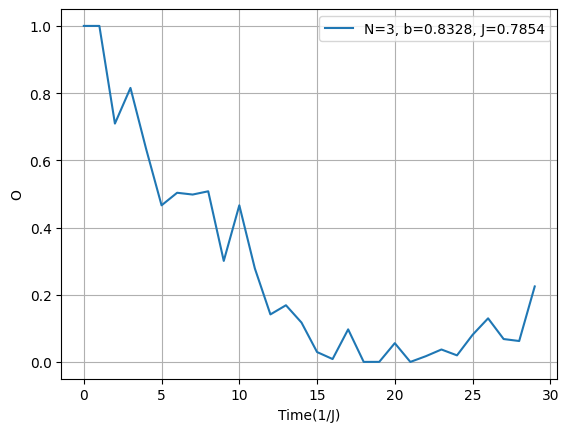

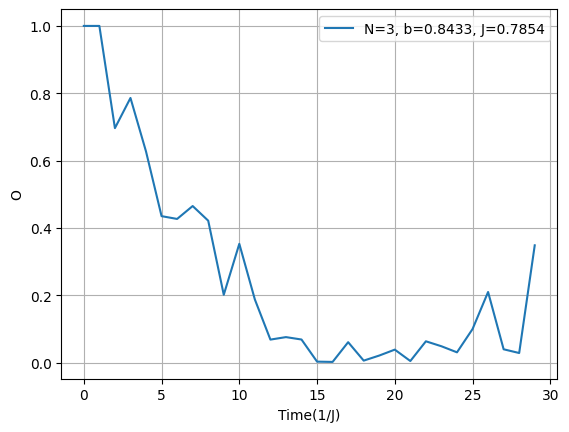

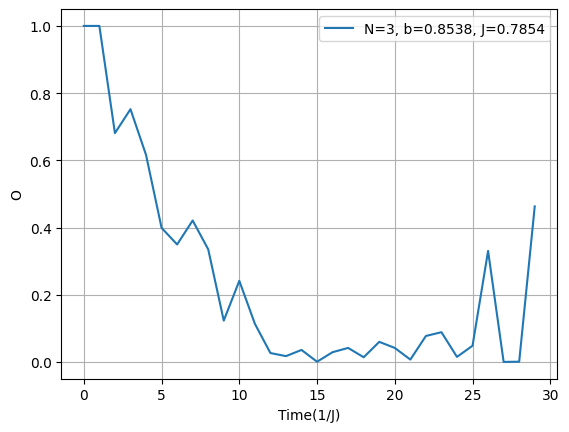

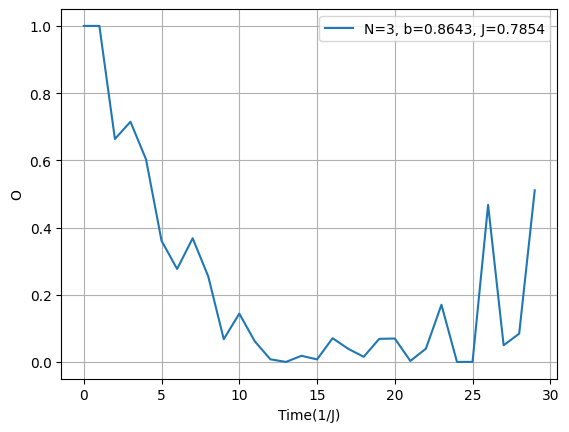

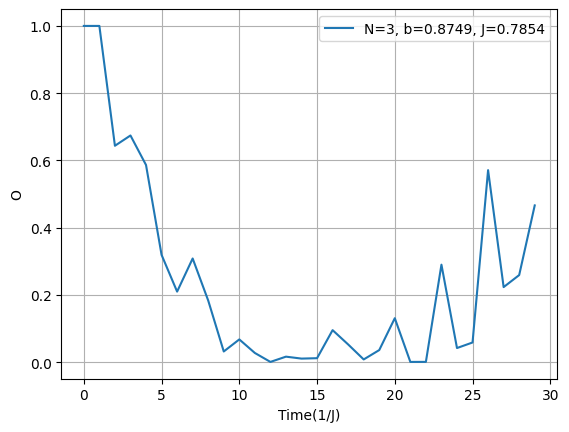

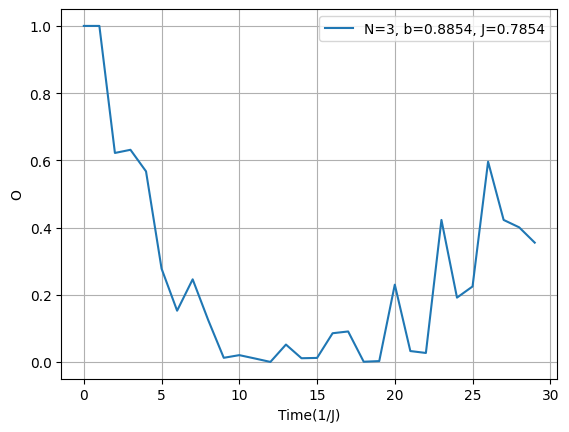

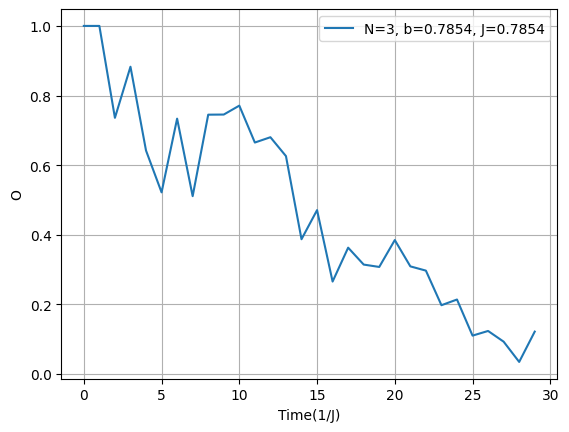

In [18]:
N=3
h = np.random.rand(N)*0.2

V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b=J = np.linspace((np.pi/4)-0.1, (np.pi/4)+0.1, 20)
b=np.append(b, np.pi/4)


for bp in b:
    cero=prueba(N,bp,np.pi/4,h, V, W, t_eval)
    ploteo(cero,t_eval, N, bp, np.pi/4)

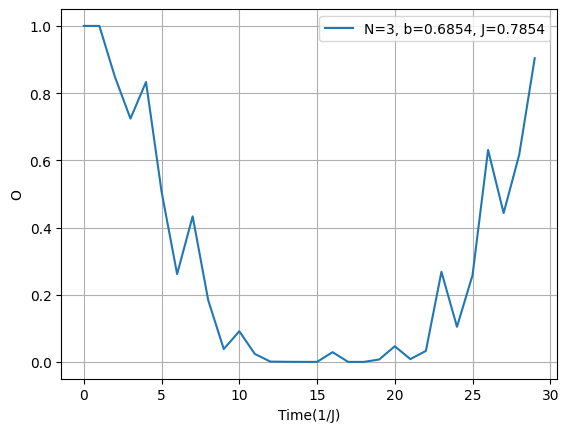

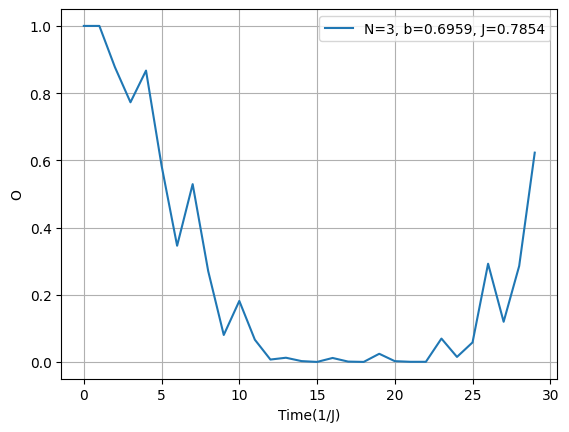

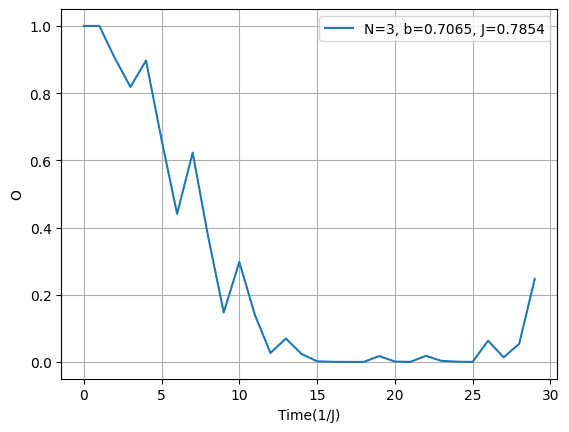

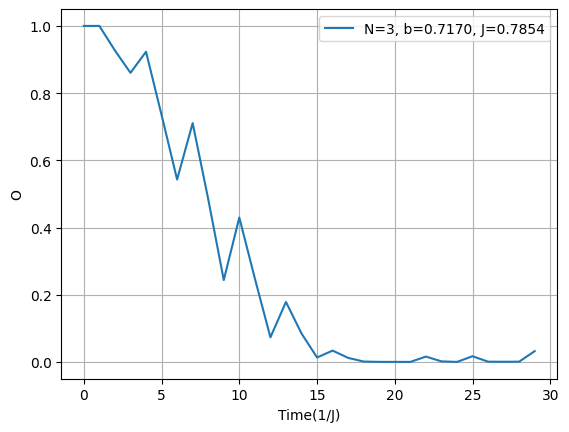

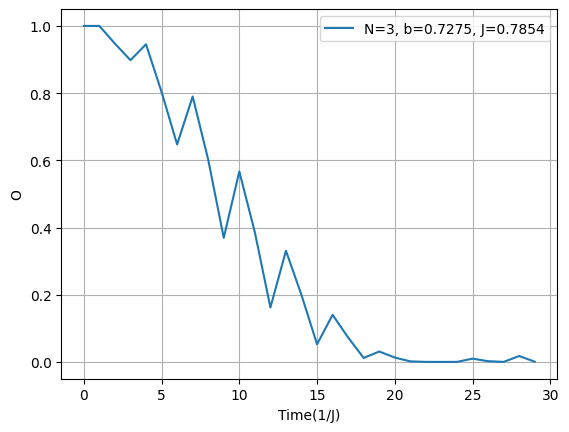

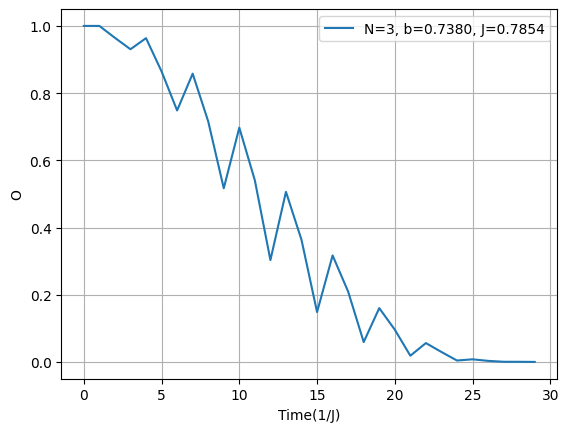

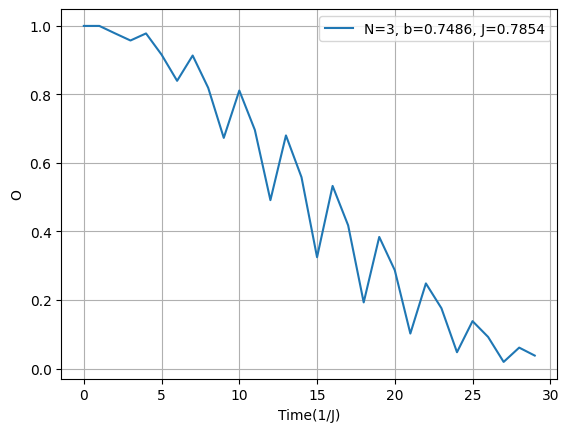

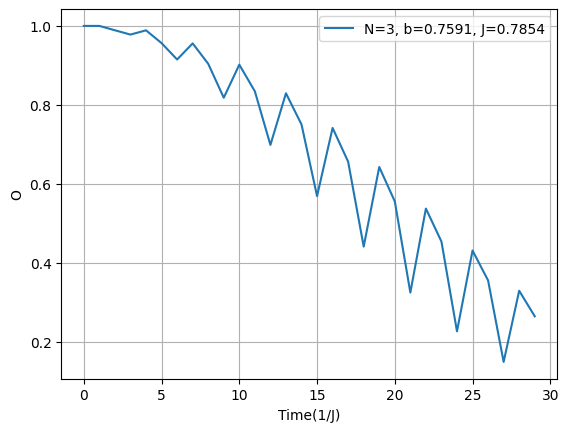

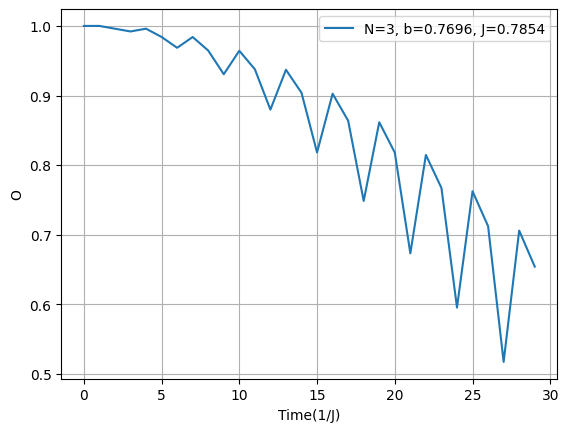

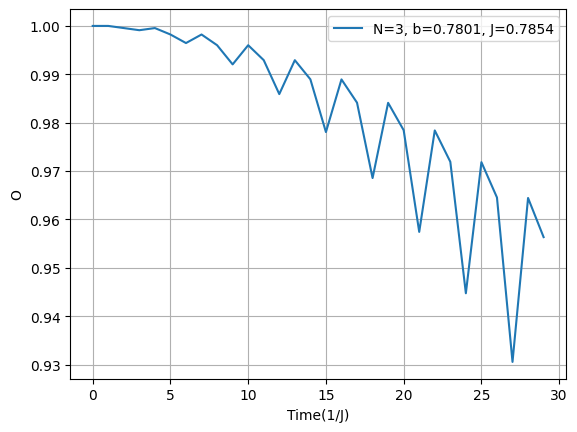

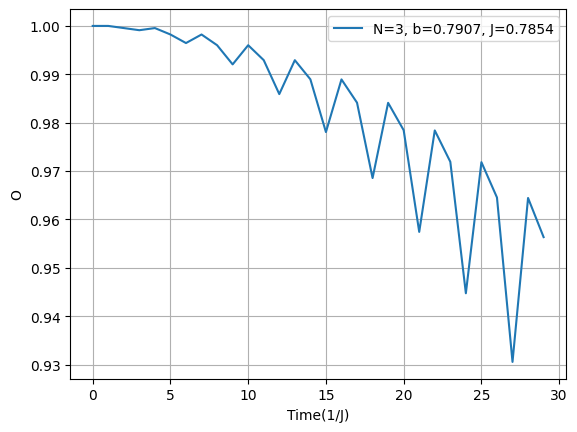

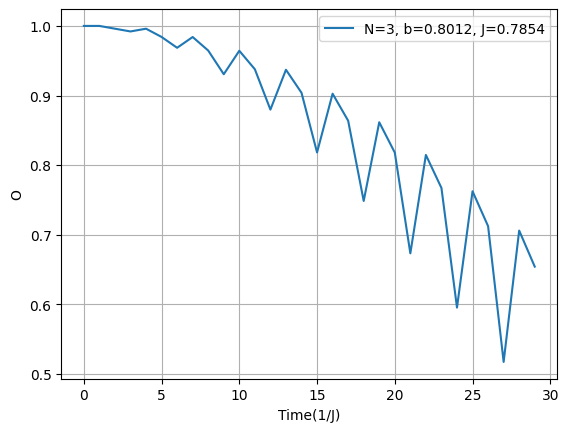

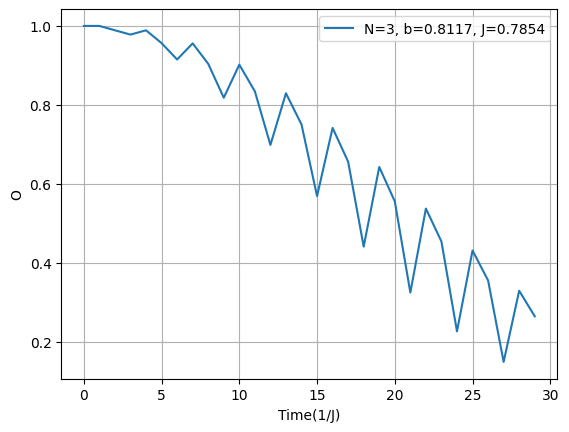

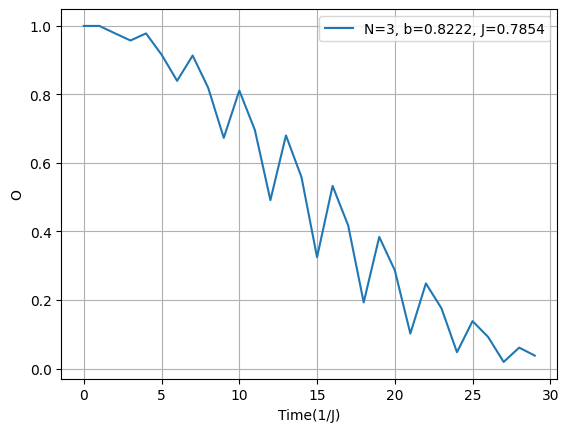

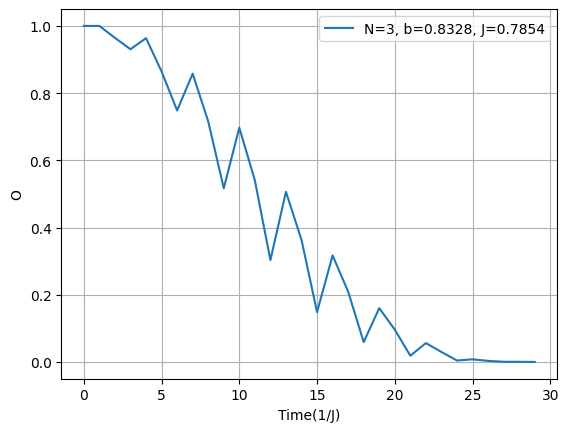

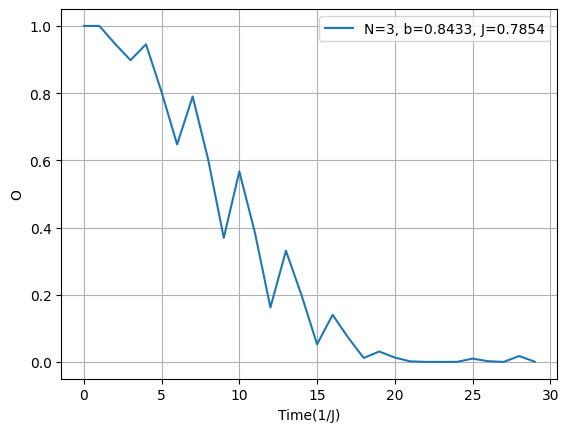

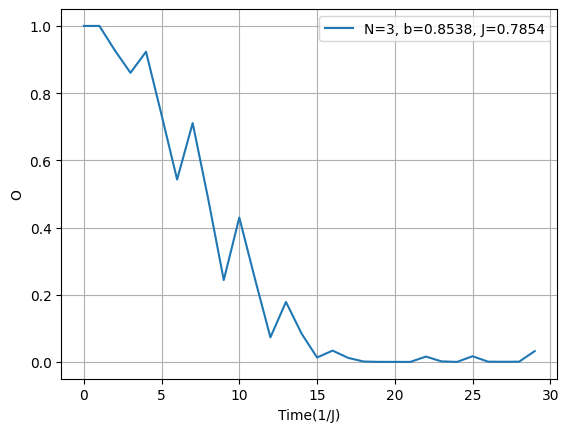

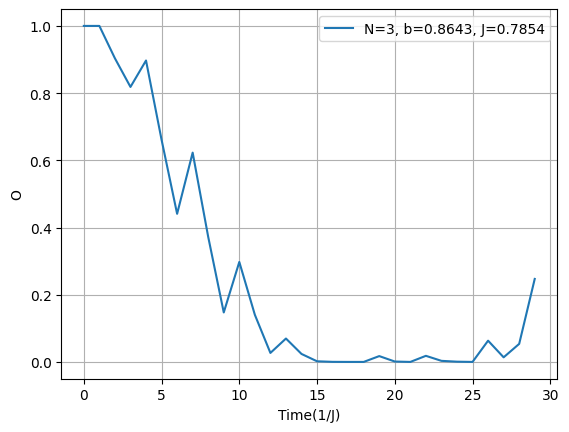

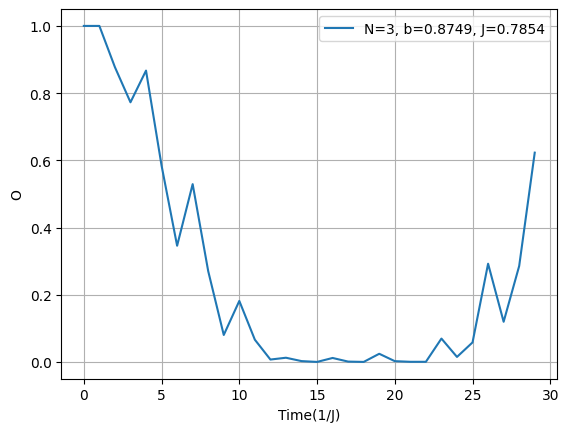

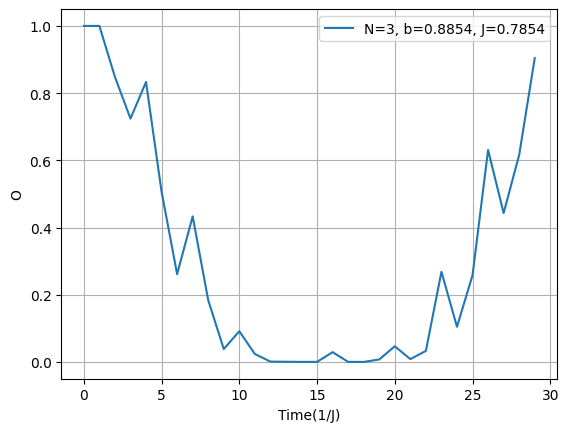

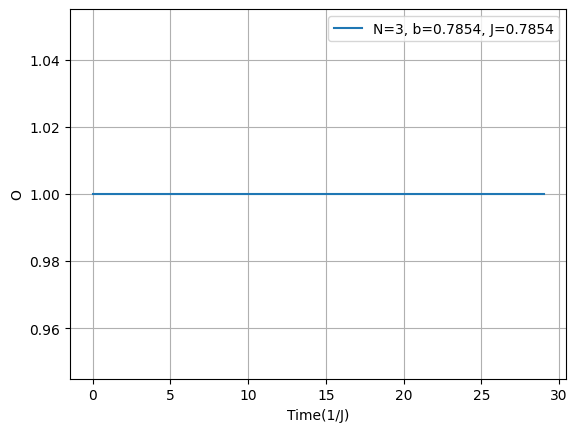

In [19]:
N=3
h = np.random.rand(N)*0.0

V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b=J = np.linspace((np.pi/4)-0.1, (np.pi/4)+0.1, 20)
b=np.append(b, np.pi/4)


for bp in b:
    cero=prueba(N,bp,np.pi/4,h, V, W, t_eval)
    ploteo(cero,t_eval, N, bp, np.pi/4)

## N=3, b=$\frac{\pi}{4}$, J=variando, h=0, V=XII, W=IXI

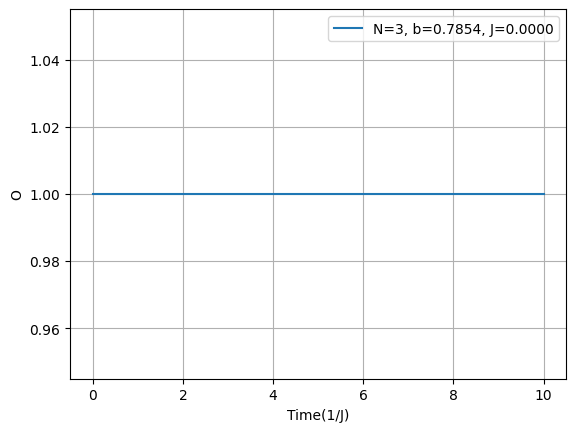

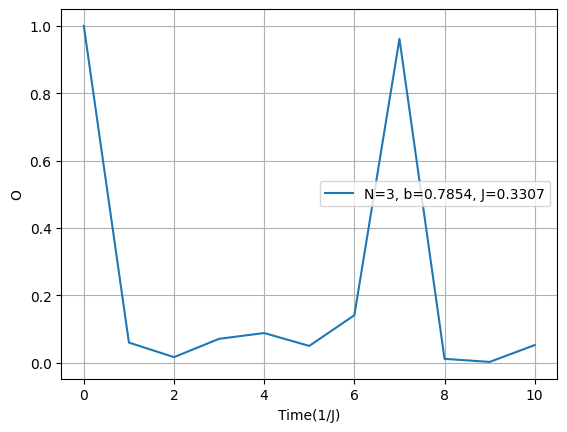

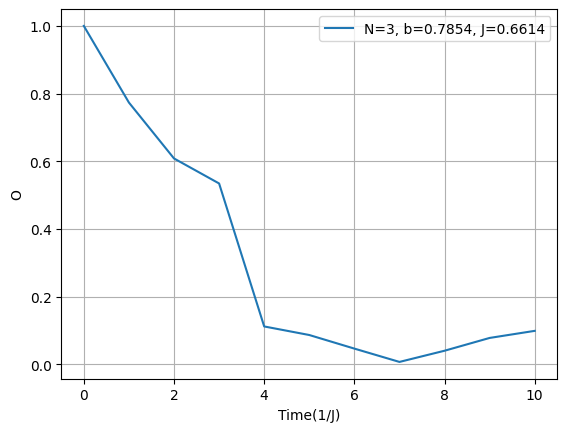

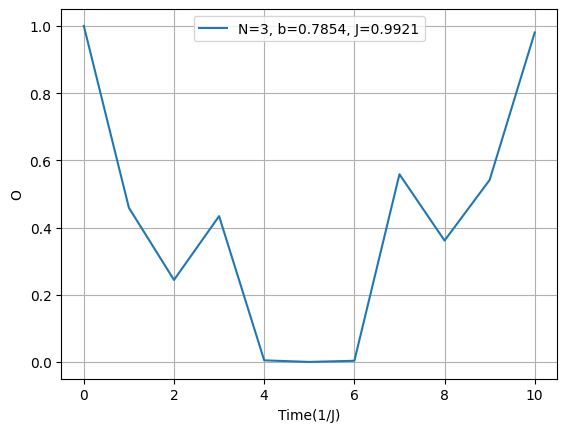

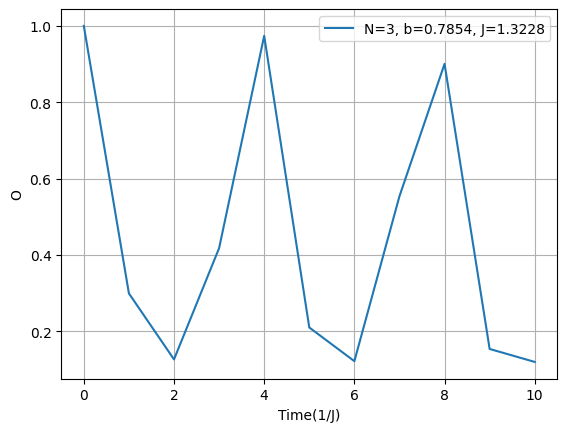

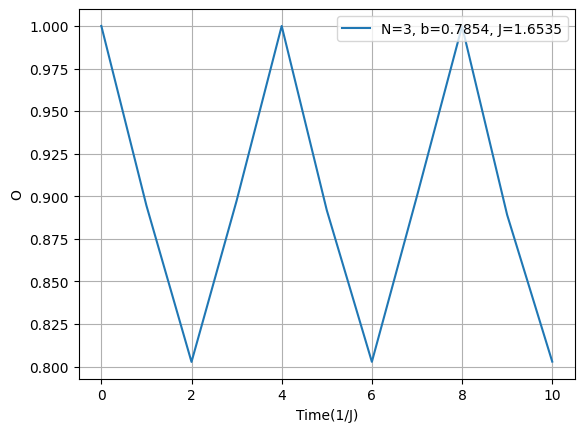

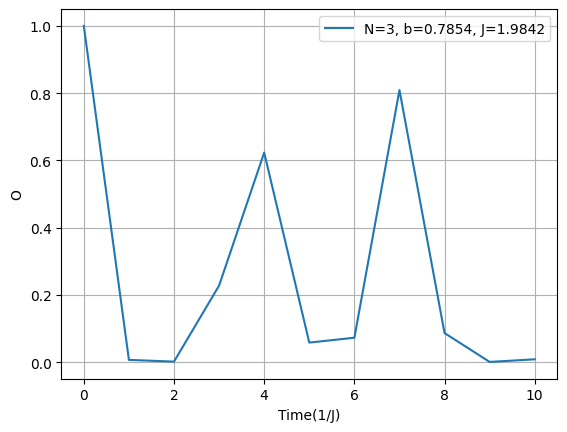

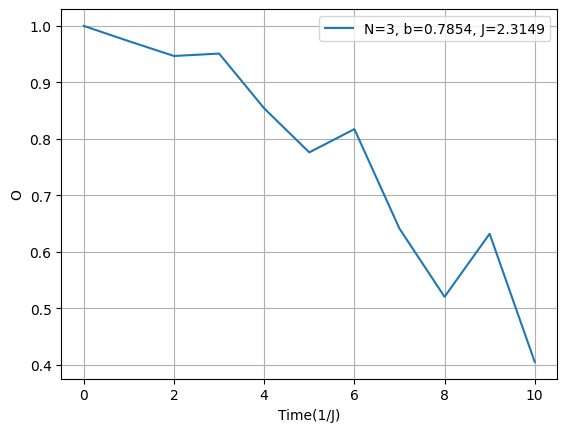

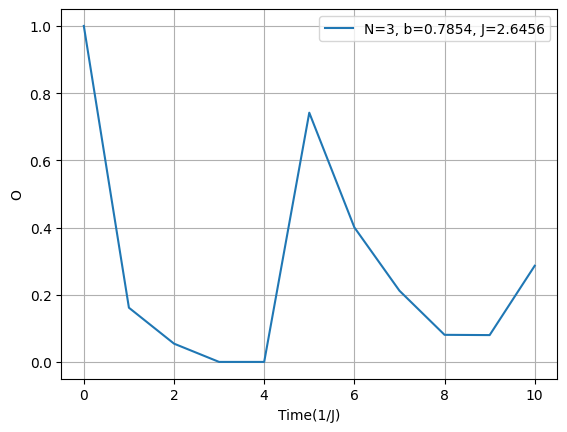

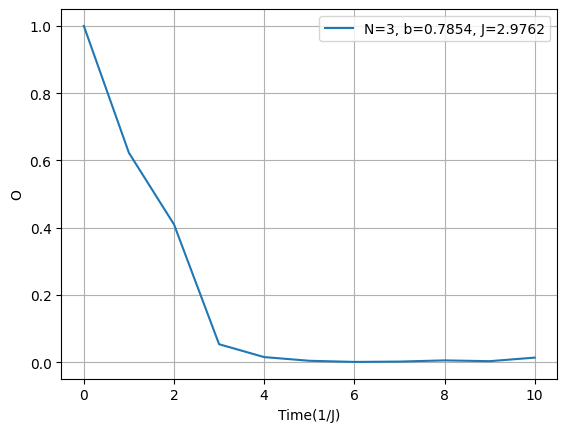

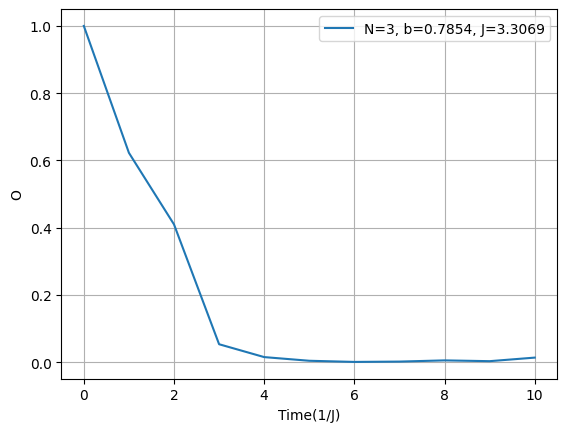

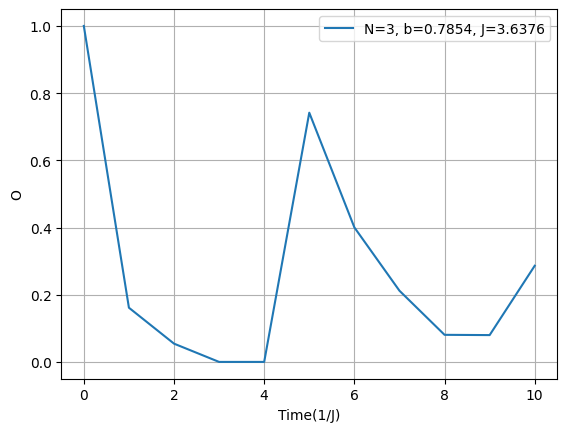

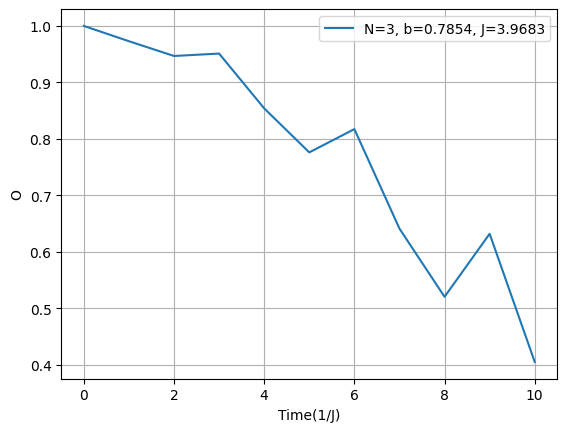

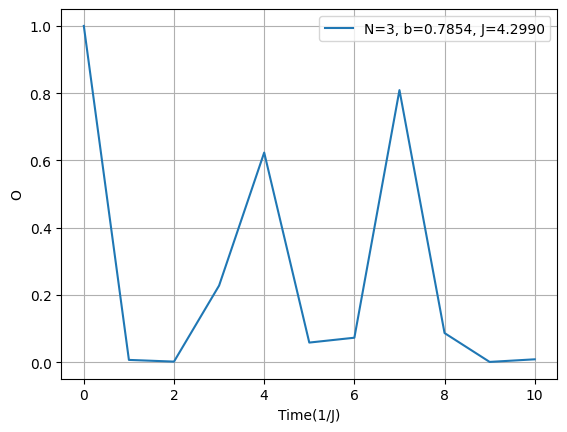

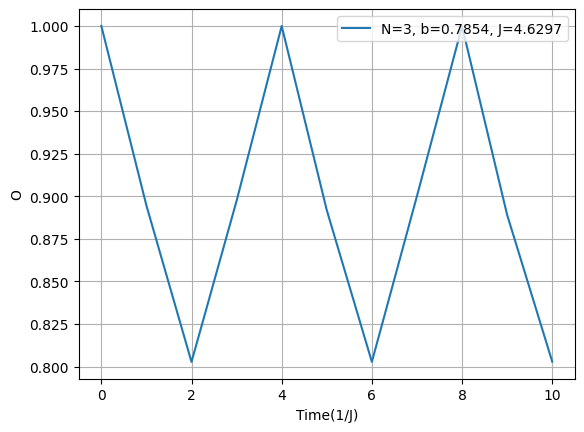

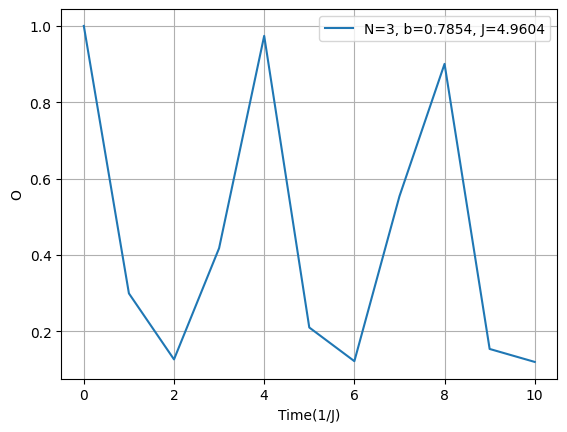

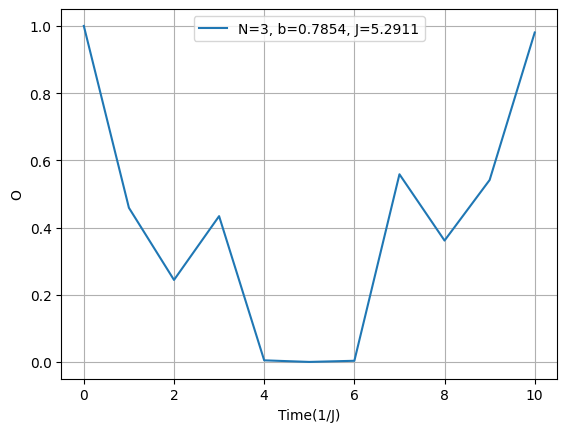

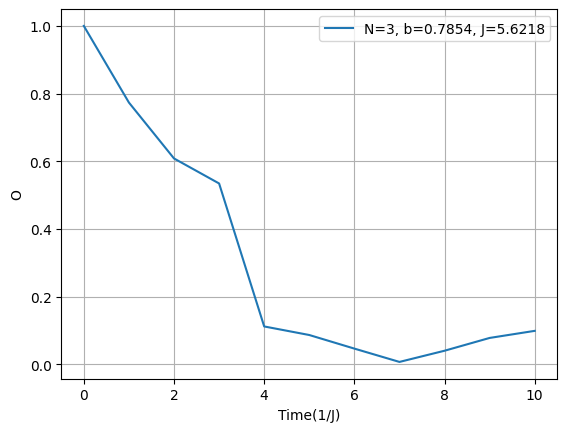

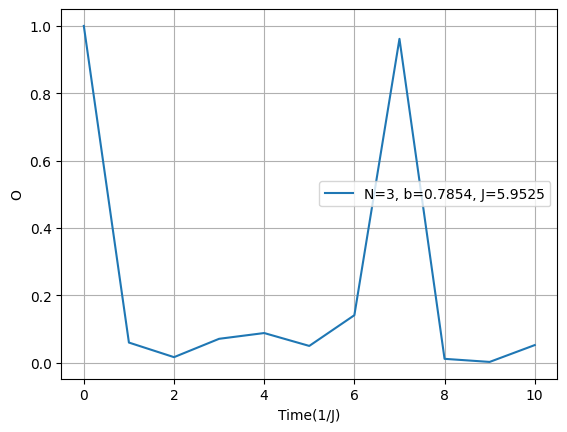

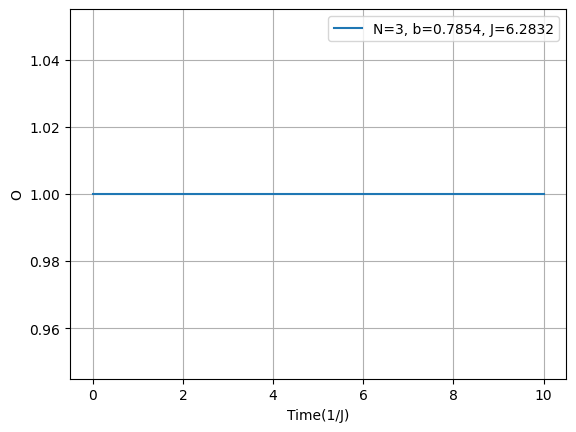

In [74]:
N=3
b=np.pi/4
h = np.zeros(N)
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(11))



J = np.linspace(0, 2*np.pi, 20)

for bp in J:
    cero=prueba(N,b,bp,h, V, W, t_eval)
    ploteo(cero,t_eval, N, b, bp)

## N=3, b=variando, J=$\frac{\pi}{4}$, h=0, V=XII, W=IXI

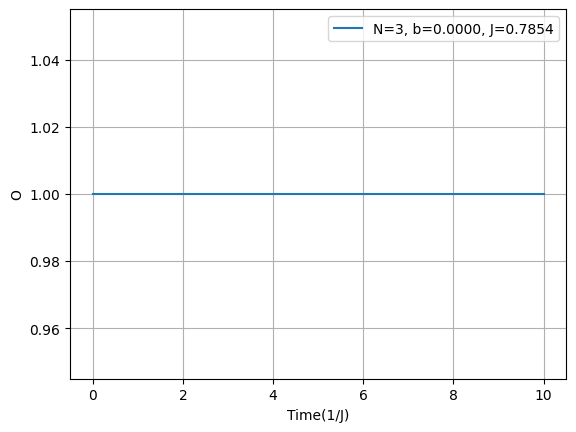

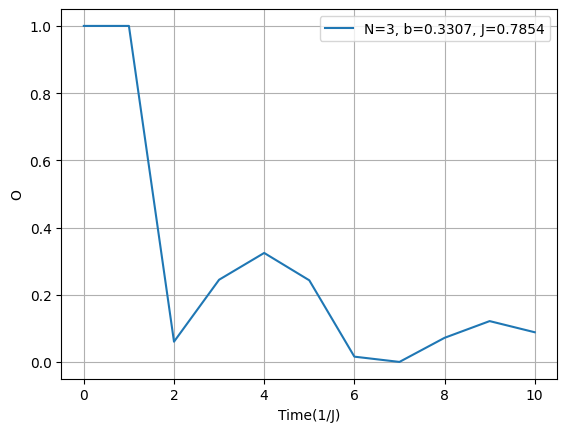

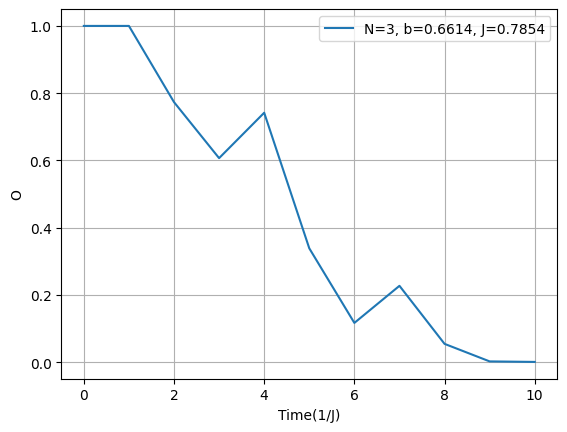

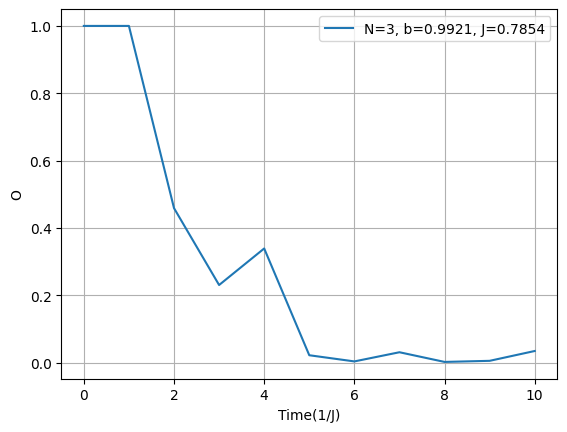

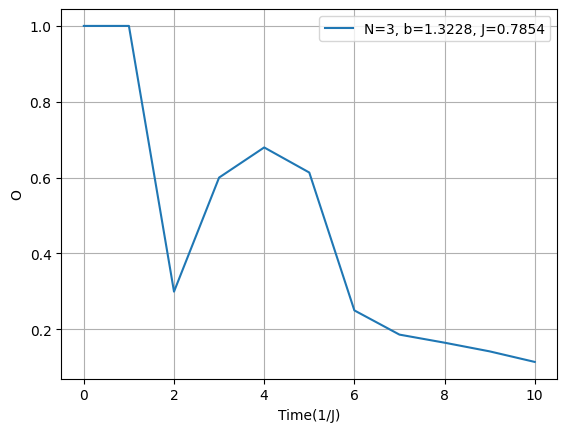

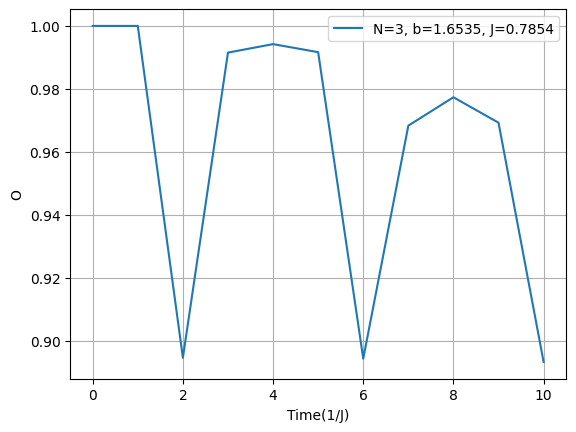

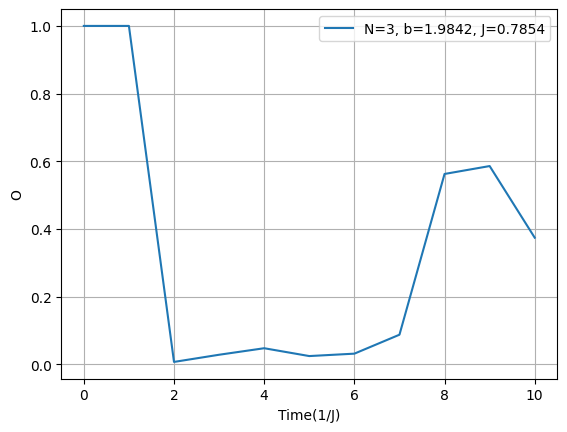

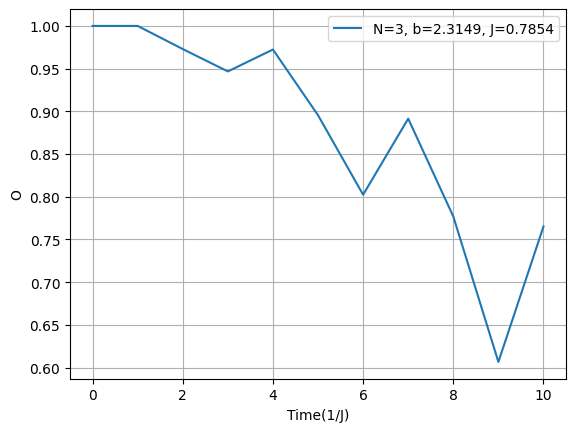

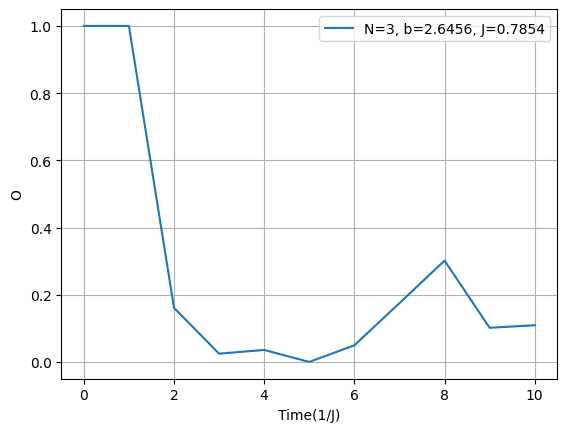

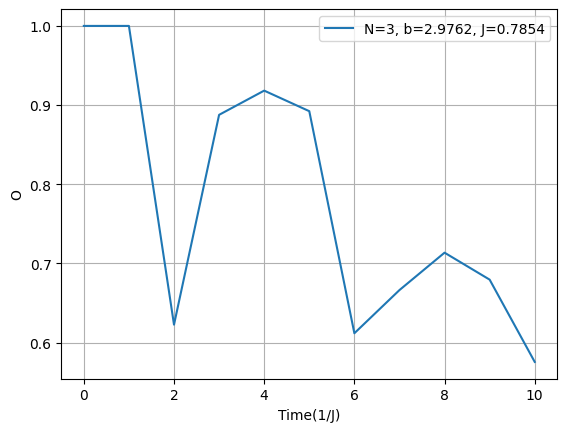

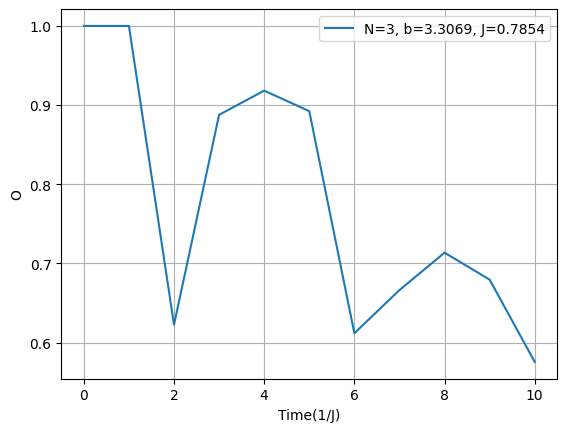

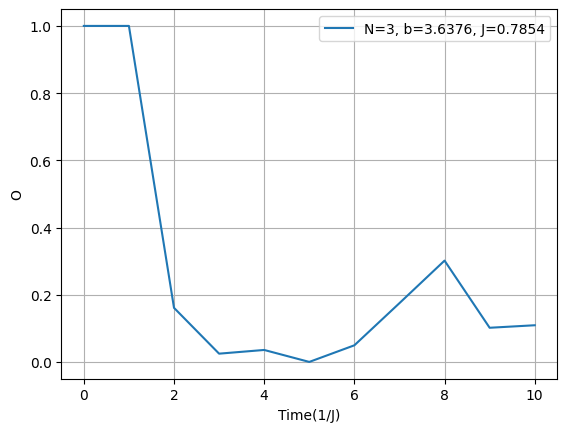

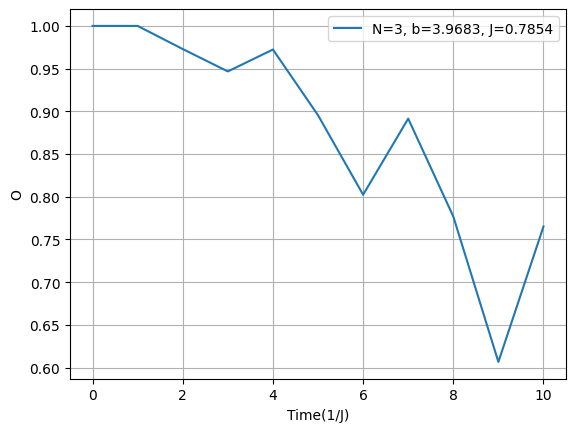

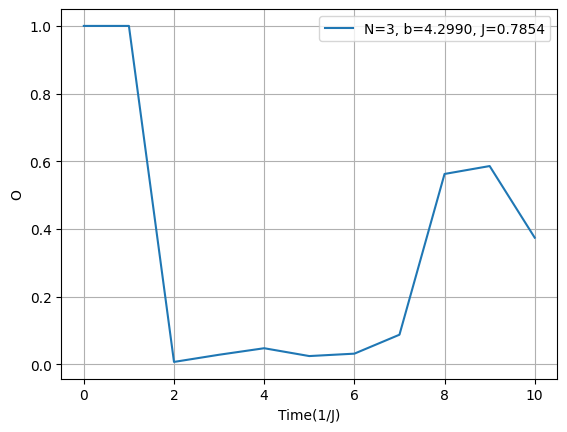

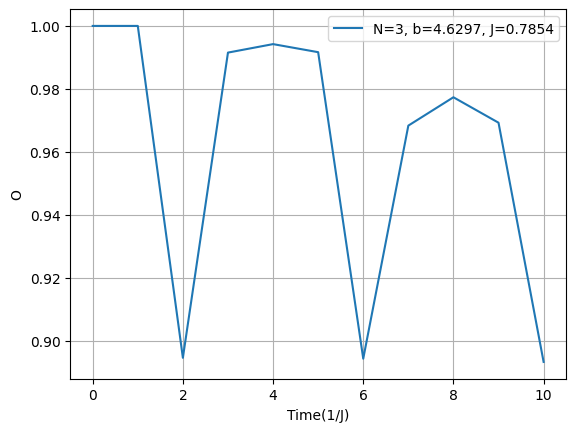

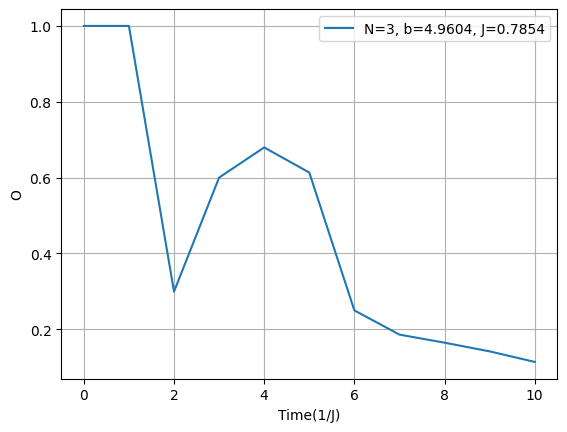

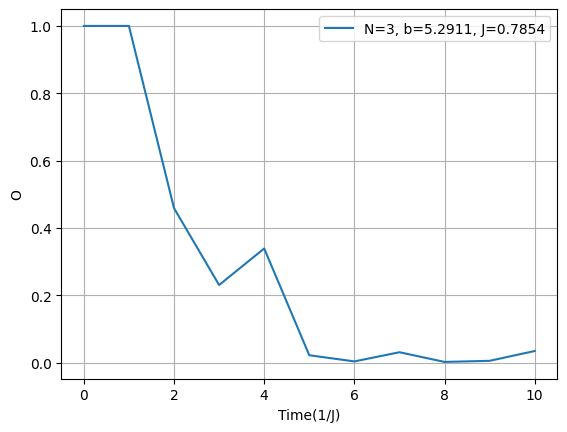

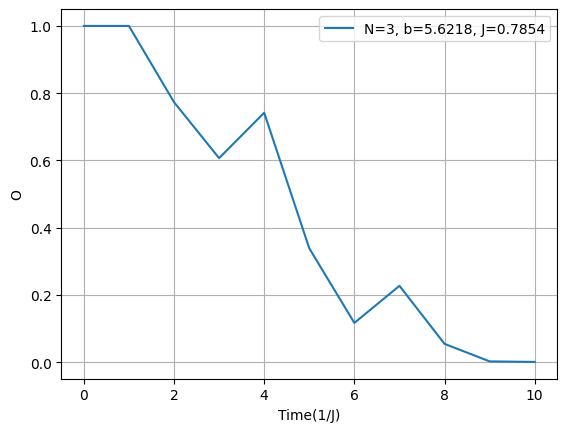

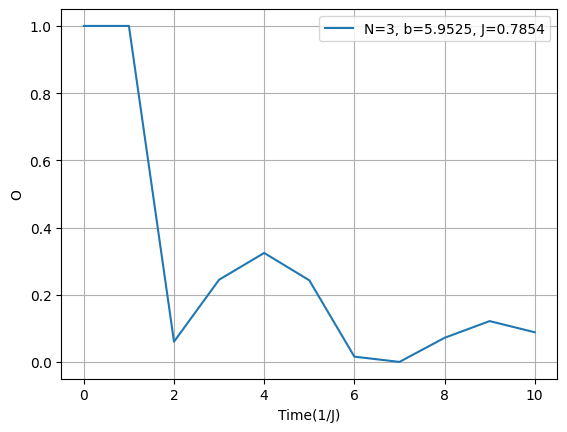

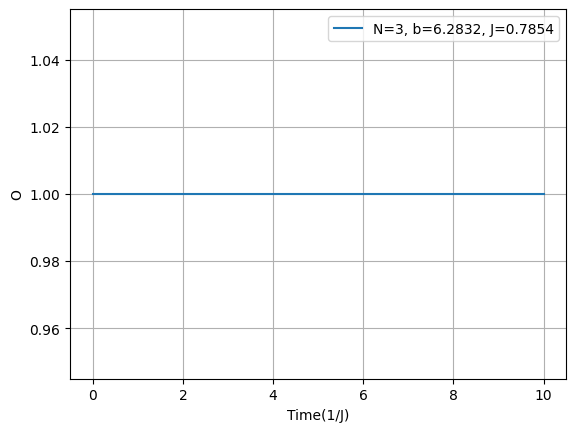

In [75]:
N=3
J=np.pi/4
h = np.zeros(N)
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(11))

b = np.linspace(0, 2*np.pi, 20)

for bp in b:
    cero=prueba(N,bp,J,h, V, W, t_eval)
    ploteo(cero,t_eval, N, bp, J)

## N=3, b=J=$\frac{\pi}{4}$, h=variando, V=XII, W=IXI

Instruction(name='pauli', num_qubits=3, num_clbits=0, params=['IXI'])


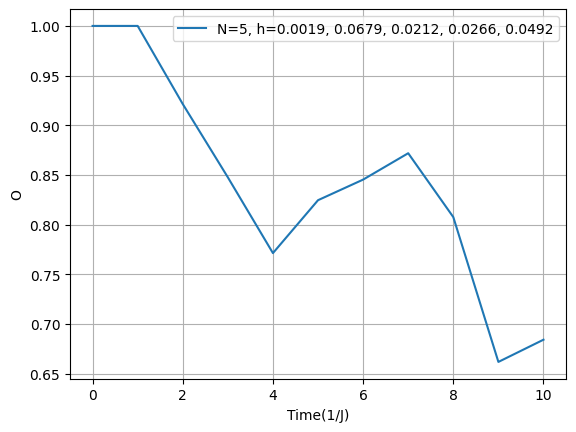

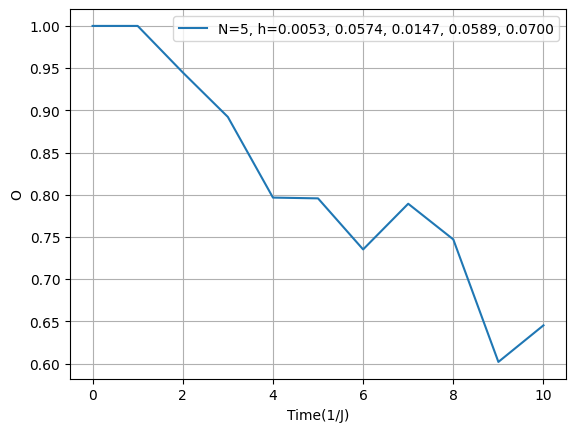

In [76]:
N=5
b=J=np.pi/4
h_list = [np.random.rand(N) for _ in range(10)]
h_peque=[np.random.rand(N)*0.1 for _ in range(2)]
h_list=h_peque
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
print(W)
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(11))


for h in h_list:
    cero=prueba(N,b,J,h, V, W, t_eval)
    ploteo1(cero,t_eval, N, h)

## N=3, b=J=$\frac{\pi}{4}$, h=0, V=variando, W=IXI


In [77]:
N=3
b=J=np.pi/4
h=np.zeros(N)
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])
t_eval=list(range(11))

### V=YII

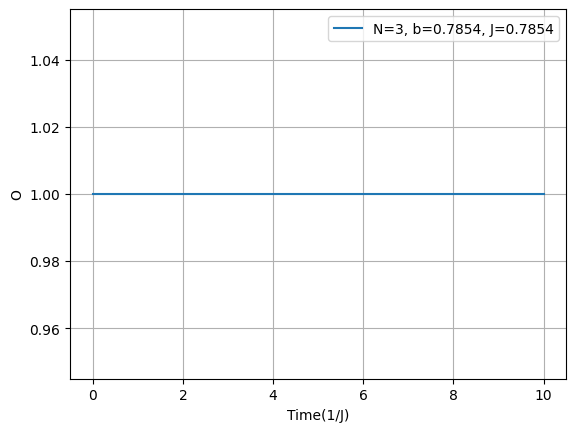

In [78]:
V=PauliGate(['I'*(i-1) + 'Y' + 'I'*(N-i) for i in [int(N/2)]][0])


cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

### V=ZII

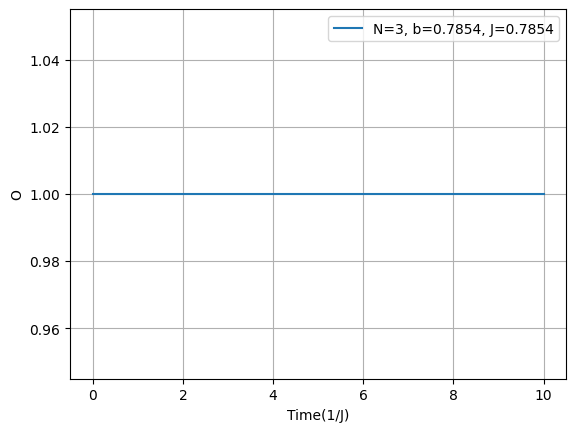

In [79]:
V=PauliGate(['I'*(i-1) + 'Z' + 'I'*(N-i) for i in [int(N/2)]][0])


cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

### V=XXI



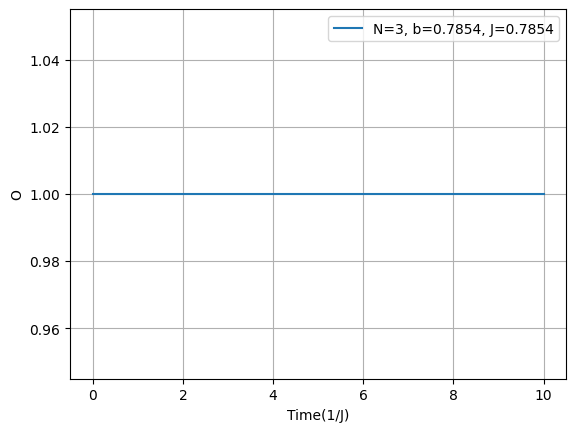

In [80]:
V=PauliGate(['I'*(i-1) + 'XX' + 'I'*(N-i-1) for i in [int(N/2)]][0])

cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

## N=3, b=J=$\frac{\pi}{4}$, h=0,V=XII, W=variando


In [81]:
N=3
b=J=np.pi/4
h=np.zeros(N)
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
t_eval=list(range(11))

### W=IYI

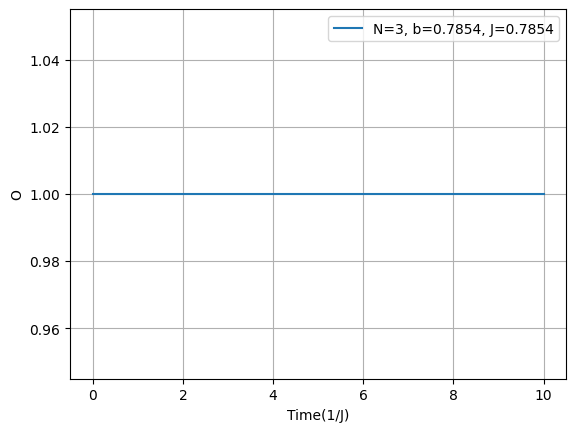

In [82]:
W=PauliGate(['I'*i + 'Y' + 'I'*(N-1-i) for i in [int(N/2)]][0])


cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

### W=IZI

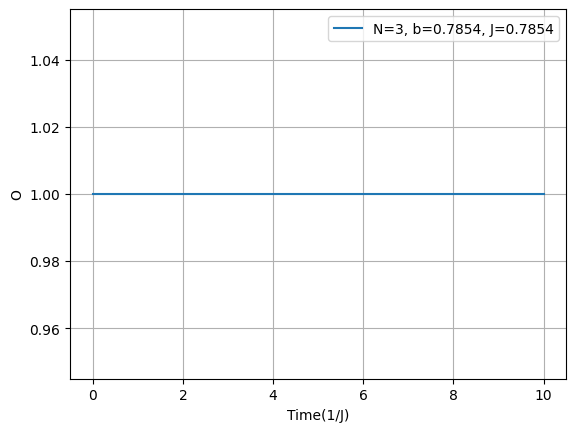

In [83]:
W=PauliGate(['I'*i + 'Z' + 'I'*(N-1-i) for i in [int(N/2)]][0])


cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

### W=IXX

Instruction(name='pauli', num_qubits=3, num_clbits=0, params=['IXX'])


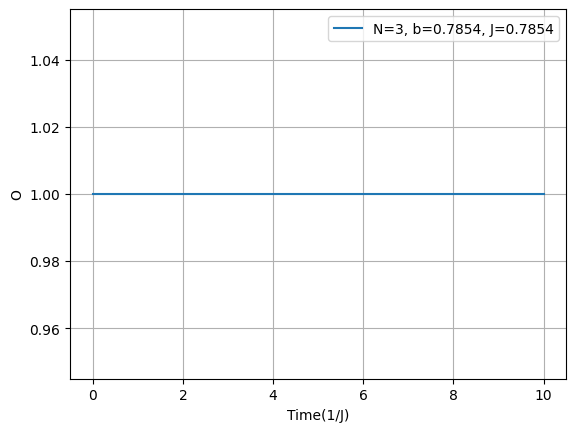

In [84]:
W=PauliGate(['I'*i + 'XX' + 'I'*(N-2-i) for i in [int(N/2)]][0])
print(W)

cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

## N=3, b=J=$\frac{\pi}{4}$, h=0, V=variando, W=Variando


In [85]:
N=3
b=J=np.pi/4
h=np.zeros(N)
t_eval=list(range(11))

### V=YII, W=IYI

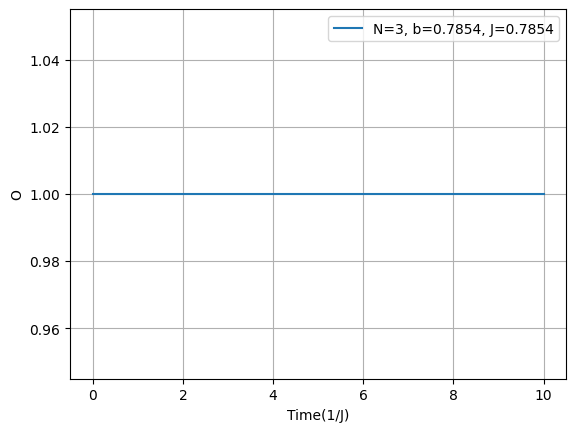

In [86]:
V=PauliGate(['I'*(i-1) + 'Y' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'Y' + 'I'*(N-1-i) for i in [int(N/2)]][0])


cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

## N=10??

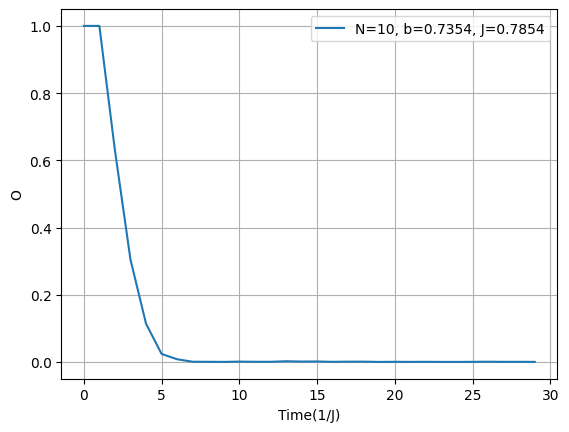

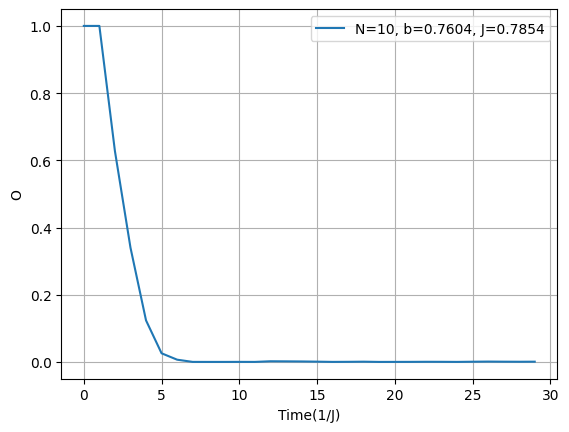

In [20]:
N=10
h = np.random.rand(N)*0.2

V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b=J = np.linspace((np.pi/4)-0.05, (np.pi/4)+0.05, 5)
b=np.append(b, np.pi/4)


for bp in b:
    cero=prueba(N,bp,np.pi/4,h, V, W, t_eval)
    ploteo(cero,t_eval, N, bp, np.pi/4)

In [11]:
N=10
h = np.random.rand(N)*0.2

V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b=np.pi/4



cero=prueba(N,b,np.pi/4,h, V, W, t_eval)
ploteo(cero,t_eval, N, b, np.pi/4)

KeyboardInterrupt: 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

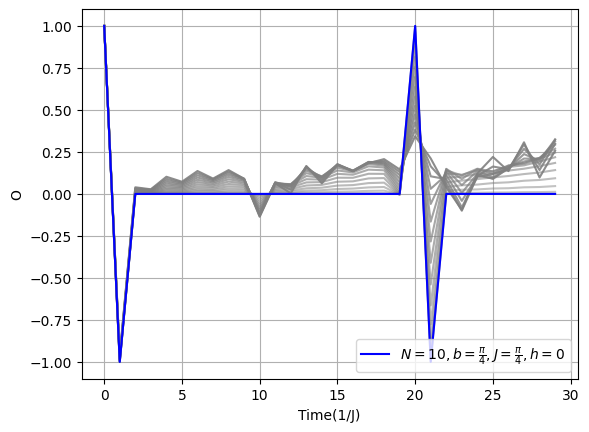

In [14]:
N=10
h = np.zeros(N)
X1=Operator(PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0]))
X2=Operator(PauliGate(['I'*(i-1) + 'Z' + 'I'*(N-i) for i in [int(N/2)]][0]))


V=1/np.sqrt(2)*(X1+1j*X2)
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')



for i,bp in enumerate(b):
    cero=OTOC_tr(t_eval, V,W, N, bp, np.pi/4, h)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero=OTOC_tr(t_eval, V,W, N, np.pi/4, np.pi/4, h)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=10, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h=0$")


plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
12
0
1
2
3
4
5

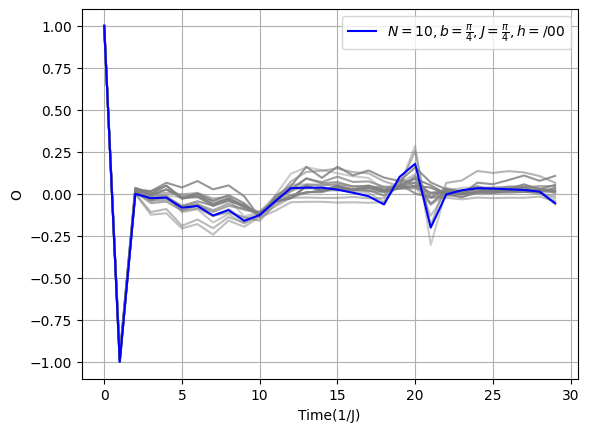

In [15]:
N=10
h = np.random.rand(N)*0.2
X1=Operator(PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0]))
X2=Operator(PauliGate(['I'*(i-1) + 'Z' + 'I'*(N-i) for i in [int(N/2)]][0]))


V=1/np.sqrt(2)*(X1+1j*X2)
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(30))

b = np.linspace((np.pi/4)-0.1, (np.pi/4), 15)

alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')



for i,bp in enumerate(b):
    print(i)
    cero=OTOC_tr(t_eval, V,W, N, bp, np.pi/4, h)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero=OTOC_tr(t_eval, V,W, N, np.pi/4, np.pi/4, h)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=10, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h=/00$")


plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.show()

## Comprobación analítica

In [87]:
N=3
b=J=np.pi/4
h=np.zeros(N)
t_eval=list(range(11))

left_reg = QuantumRegister(N, 'Left')
right_reg = QuantumRegister(N, 'Right')

V=PauliGate(['I'*(i-1) + 'Y' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'Y' + 'I'*(N-1-i) for i in [int(N/2)]][0])

P=PauliGate('YIY')
res=[]

terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()



qc = QuantumCircuit(left_reg, right_reg)

initialize()

qc.append(P,left_reg)

for i in range(N-1, -1, -1):
    qc.cx(left_reg[i], right_reg[i])
    qc.h(left_reg[i])

qc.measure_all()

job = sampler_v1.run(qc)
dists = job.result().quasi_dists[0] #Esta clase sólamente devuelve las quasi_dists
res.append(dists)

print(res)
#ploteo(ceros,t_eval, N, b,J)

[{45: 0.999999999999999}]


## Otra prueba

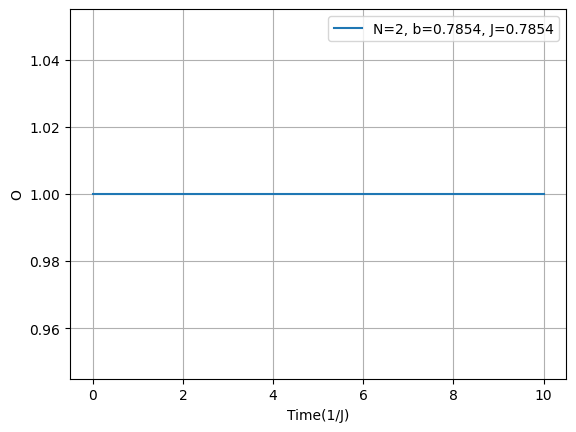

In [88]:
N=2
b=J=np.pi/4
h=np.zeros(N)
t_eval=list(range(11))

V=PauliGate(['I'*(i-1) + 'Y' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'Y' + 'I'*(N-1-i) for i in [int(N/2)]][0])


cero=prueba(N,b,J,h, V, W, t_eval)
ploteo(cero,t_eval, N, b,J)

## ISING

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
7
0
1


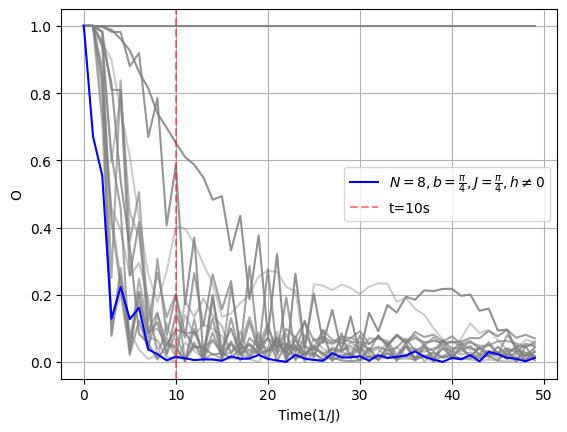

In [46]:
N=8
h = np.random.rand(N)*0.2
# h=np.array([8.34044009e-02, 1.44064899e-01, 2.28749635e-05, 6.04665145e-02, 2.93511782e-02, 1.84677190e-02, 3.72520423e-02, 6.91121454e-02])
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

t_eval=list(range(50))

b = np.linspace(0, (np.pi/4), 15)


alphas=np.linspace(0.4,0.9,15)

plt.figure(facecolor='white')



for i,bp in enumerate(b):
    print(i)
    cero=OTOC_tr(t_eval, V,W, N, bp, np.pi/4, 0.2)
    cerosnorm = cero / cero[0]

    plt.plot(t_eval, cerosnorm, color='grey',alpha=alphas[-1-i])

cero=OTOC_tr_ising(t_eval, V,W, N, np.pi/4, np.pi/4, 0.2)
cerosnorm = cero / cero[0]
plt.plot(t_eval, cerosnorm ,color='blue', label=r"$N=8, b=\frac{\pi}{4}, J=\frac{\pi}{4}, h\neq0$")

plt.axvline(x=10, color='red', linestyle='--',label='t=10s',alpha=0.5)
plt.xlabel(r'Time(1/J)')
plt.ylabel(r'O')
plt.legend()
plt.grid()
plt.savefig('OTOC traza BKP varios N=8 t=150.pdf', dpi=400)
plt.show()

In [ ]:
colors = plt.cm.tab20(np.linspace(0, 1, 2*N+m))

plt.figure(7)
for i in range(2*N+m):
    plt.plot(range(51), ch_total2[i],'.',color=colors[i], label=f'{str((2*N+m-1)-i)}')
plt.axvline(x=8, color='red', linestyle='--',label='t=8s',alpha=0.5)
plt.title(r'Teleportación a través de los canales')
plt.legend(loc='upper right',ncol=5)
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.ylim(-1, 1.5)
plt.grid()
plt.savefig(f'sigmaz vs time N={N} weno.pdf', dpi=400)  # Save the plot as PDF
plt.show()